<a href="https://www.kaggle.com/code/sofiamatias/icecube-train?scriptVersionId=123836515" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Concepts and ideas

## How zenith and azimuth gives a direction
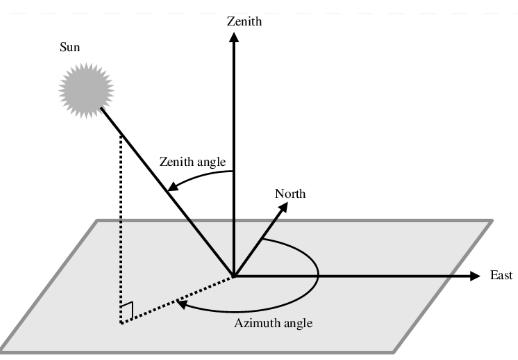

# Merge Data

In [1]:
def get_train_df_from_a_batch (train_batch_df, sensors_df, train_meta_df, batch_number):
    """
    Converts train_batch, train_meta and sensor_geometry into a 'train_df' dataframe containing features and targets
    It filters 'auxiliary' field to only 'False' values (reduces db in 27%), due to challenge explanation:
    ' If True, the pulse was not fully digitized, is of lower quality, and was more likely to originate from noise.'
    It uses polars dataframes only.
    """
    train_batch_df = train_batch_df.filter(pl.col("auxiliary") == False)
    sensors_df = sensors_df.with_columns(pl.col('sensor_id').cast(pl.Int16, strict=False))
    train_df = train_batch_df.join (sensors_df, how='left', on = 'sensor_id')
    train_meta_batch_df = train_meta_df.filter(pl.col("batch_id") == batch_number)
    train_df = train_df.join (train_meta_batch_df, how='left', on = 'event_id')
    train_df = train_df.drop (columns=['batch_id', 'auxiliary']) #train_df is filtered for 1 batch_id and auxiliary = False, these columns are useless
    train_df = train_df.drop (columns=['sensor_id', 'first_pulse_index', 'last_pulse_index'])
    del train_meta_batch_df #memory
    del train_batch_df #memory
    print (f'Train dataframe:\n')
    print (train_df)
    return train_df

# EDA

In [2]:
def EDA_report (data):
    """
    Generates an EDA report using sweetviz package. Use "data" as your dataset
    """
    import datetime
    import sweetviz as sw
    from IPython.display import FileLink, display

    now = datetime.datetime.now()
    report_filename = f'EDA_report{now}.html'

    analyze_report = sw.analyze(data)
    analyze_report.show_html(report_filename, open_browser = True)
    
    link = FileLink (report_filename)
    print ('\nClick here to open report:')
    display(link)

    return None

## Correlations

In [3]:
#train_analysis = train_df.collect().sample(frac=0.001)
#EDA_report (train_analysis.to_pandas())
#display(train_analysis)

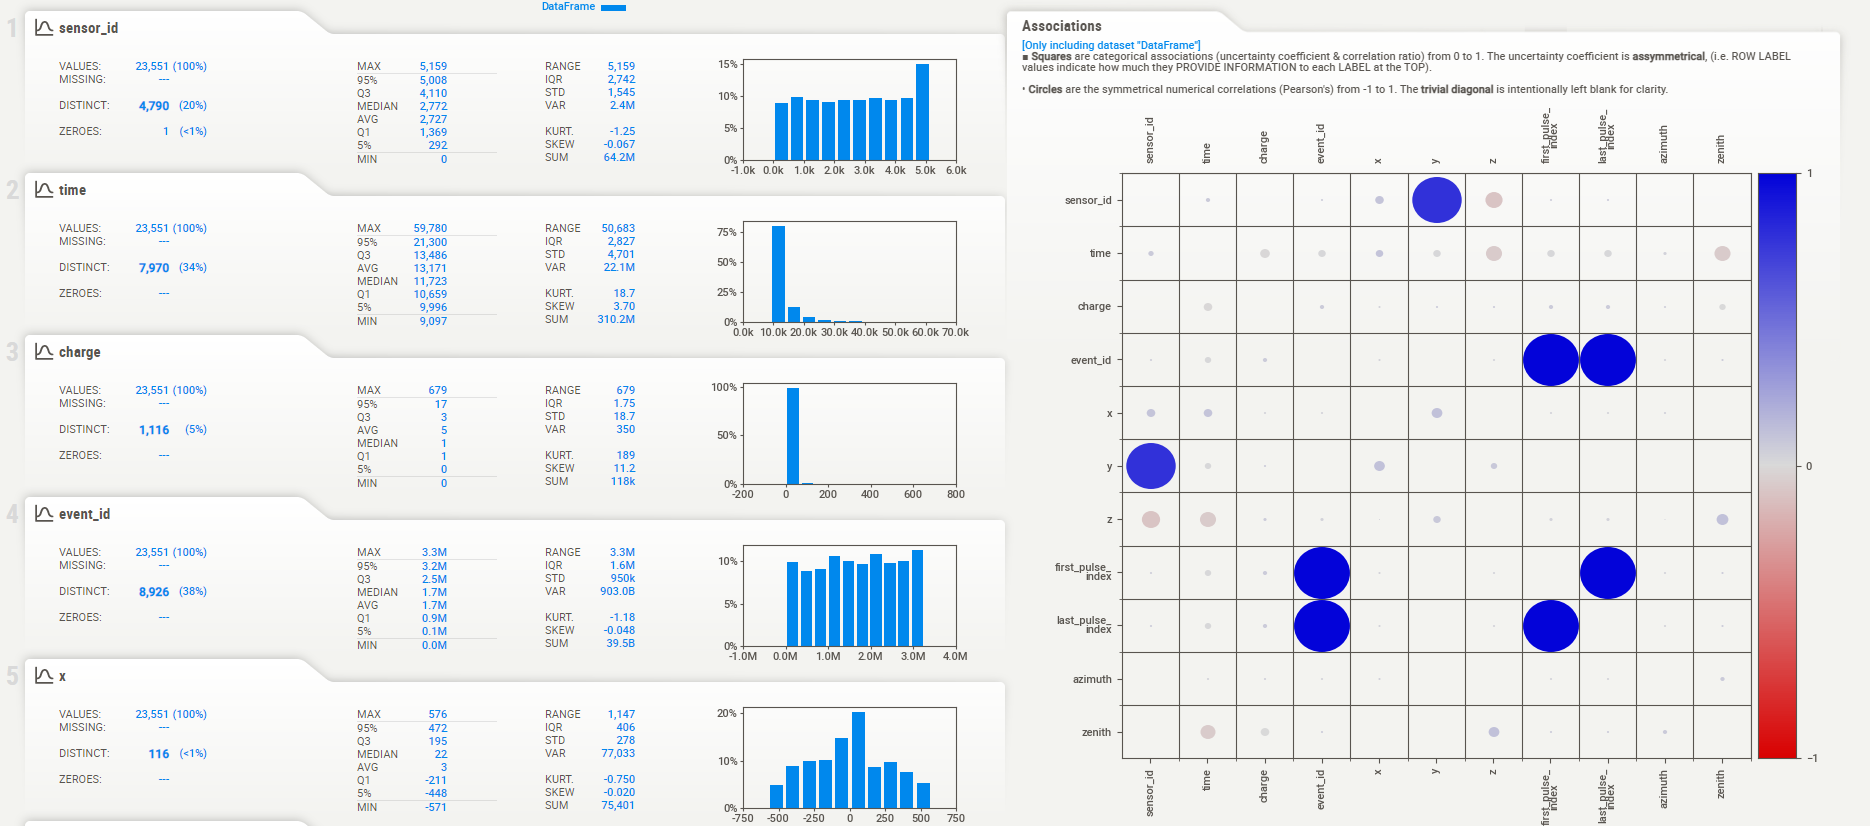
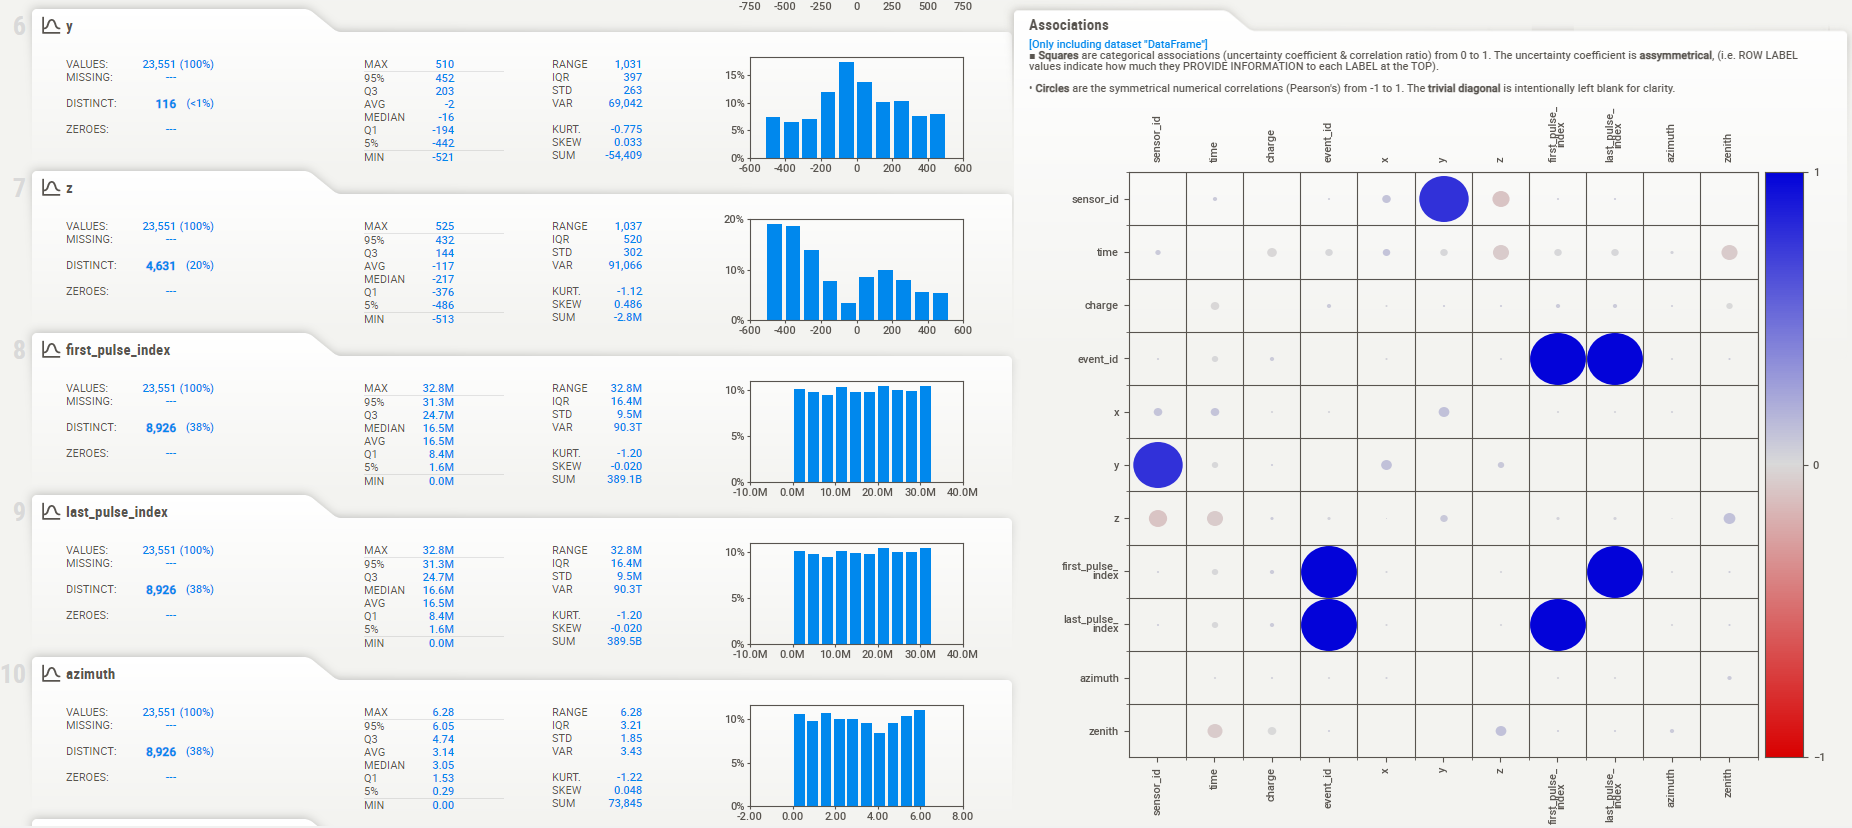

In [4]:
# Utility functions from Tutorial
def make_mi_scores(X, y):
    
    from sklearn.feature_selection import mutual_info_regression
    
    for colname in ["object", "category"]:
        if colname in X.dtypes:
            X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#X = train_analysis.to_pandas()
#y_az = X['azimuth']
#X = X.drop (columns = ['azimuth'])
#mi_scores = make_mi_scores(X, y_az)
#del train_analysis #memory
#mi_scores

# Score Function

In [5]:
def angular_dist_score(az_true, zen_true, az_pred, zen_pred, batch_size=1000):
    '''
    calculate the MAE of the angular distance between two directions.
    The two vectors are first converted to cartesian unit vectors,
    and then their scalar product is computed, which is equal to
    the cosine of the angle between the two vectors. The inverse 
    cosine (arccos) thereof is then the angle between the two input vectors
    
    Parameters:
    -----------
    
    az_true : float (or array thereof)
        true azimuth value(s) in radian
    zen_true : float (or array thereof)
        true zenith value(s) in radian
    az_pred : float (or array thereof)
        predicted azimuth value(s) in radian
    zen_pred : float (or array thereof)
        predicted zenith value(s) in radian
    
    Returns:
    --------
    
    dist : float
        mean over the angular distance(s) in radian
    '''
    
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    
    import numexpr as ne

    n = len(az_true)
    angle_sum = 0.0
    for i in range(0, n, batch_size):
        end = min(i + batch_size, n)
        sa1 = np.sin(az_true[i:end]).astype(np.float32)
        ca1 = np.cos(az_true[i:end]).astype(np.float32)
        sz1 = np.sin(zen_true[i:end]).astype(np.float32)
        cz1 = np.cos(zen_true[i:end]).astype(np.float32)
        sa2 = np.sin(az_pred[i:end]).astype(np.float32)
        ca2 = np.cos(az_pred[i:end]).astype(np.float32)
        sz2 = np.sin(zen_pred[i:end]).astype(np.float32)
        cz2 = np.cos(zen_pred[i:end]).astype(np.float32)
        scalar_prod = ne.evaluate('sz1*sz2*(ca1*ca2 + sa1*sa2) + cz1*cz2')
        scalar_prod = np.clip(scalar_prod, -1, 1)
        angle_sum += np.sum(np.arccos(scalar_prod))
    return angle_sum / (n * batch_size) 

# Load train and test datasets functions

In [6]:
def train_and_test_set_for_hyperparameters (train_df):
    """
    From 'train_df' dataset, define train and test datasets for hyperparameters tunig for LGBM model.
    Using a fraction of total dataset (just 0.001 for fast tuning).
    Parameters: 'train_df'
    Output:
    x_sample_train - train set features
    y_sample_train_ze, y_sample_train_az - train target columns: y is split in azimuth (y_train_az) and zenith (y_train_ze) 
    x_sample_val - validation/test set features
    y_sample_val_ze, y_sample_val_az - validation/test target columns; y is split in azimuth (y_train_az) and zenith (y_train_ze)
    """

    # Getting sampled train and test datasets for hyperparameters tuning
    sampled_train = train_df.collect().sample(frac=0.001).to_pandas()
    display(sampled_train)
    y = sampled_train[['azimuth', 'zenith']]
    print ('\nSampled dataset - y: \nShape: ', y.shape, '\n')
    print(y)
    X = sampled_train.drop(columns=['azimuth', 'zenith'])
    print ('\nSampled dataset - X: \nShape: ', X.shape, '\n')
    print(X)
    x_sample_train, x_sample_val, y_train, y_val = train_test_split(X, y, random_state=42)
    print ('\nSampled train dataset - x_train:\nShape: ', x_sample_train.shape, '\n')
    print(x_sample_train)
    print ('\nSampled train dataset - y_train:\nShape: ', y_train.shape, '\n')
    print(y_train)
    x_sample_train = x_sample_train.to_numpy()
    x_sample_val = x_sample_val.to_numpy()
    y_sample_train_az = y_train['azimuth'].to_numpy()
    y_sample_train_ze = y_train['zenith'].to_numpy()
    y_sample_val_az = y_val['azimuth'].to_numpy()
    y_sample_val_ze = y_val['zenith'].to_numpy()
    
    return x_sample_train, y_sample_train_ze, y_sample_train_az, x_sample_val, y_sample_val_ze, y_sample_val_az

In [7]:
def train_and_test_set_for_model (train_df):
    """
    From 'train_df' dataset, define train and test datasets for LGBM model training.
    Using a fraction of total dataset.
    Parameters: 'train_df'
    Output:
    x_train - train set features
    y_train_ze, y_train_az - train target columns: y is split in azimuth (y_train_az) and zenith (y_train_ze) 
    x_val - validation/test set features
    y_val_ze, y_val_az - validation/test target columns; y is split in azimuth (y_train_az) and zenith (y_train_ze)
    """

    # Getting train and test datasets for model fit
    train_data = train_df.collect().sample(frac=0.1)
    y = train_data.select(['azimuth', 'zenith'])
    print ("\nTarget y:\nShape: ", y.shape, "\n")
    print(y)
    X = train_data.drop(['azimuth', 'zenith'])
    print ("\nFeatures X y:\nShape: ", X.shape, "\n")
    print(X)
    x_train, x_val, y_train, y_val = train_test_split(X, y, random_state=42)
    print ("\nFeatures x_train for train set:\nShape: ", x_train.shape, "\n")
    print(x_train)
    print ("\nTarget y_train for train set:\nShape: ", y_train.shape, "\n")
    print(y_train)
    x_train = x_train.to_numpy()
    x_val = x_val.to_numpy()
    y_train_az = y_train.select('azimuth').to_numpy().squeeze()
    y_train_ze = y_train.select('zenith').to_numpy()
    y_val_az = y_val.select('azimuth').to_numpy().squeeze()
    y_val_ze = y_val.select('zenith').to_numpy()
    
    return x_train, y_train_ze, y_train_az, x_val, y_val_ze, y_val_az

# Hyperparameter tuning function

In [8]:
def parameters (x_sample_train, y_sample_train_ze, y_sample_train_az, x_sample_val, y_sample_val_ze, y_sample_val_az):
    """
    Gets hyperparameters for LGBM model using optuna. 
    'x_sample_train' for 'model_az' includes the 'y_sample_train_ze', meaning that azimuth features includes zenith values.
    Model metric used in 'mean_absolute_error'.
    Parameters:
    x_sample_train - train set features
    y_sample_train_ze, y_sample_train_az - train target columns: y is split in azimuth (y_train_az) and zenith (y_train_ze) 
    x_sample_val - validation/test set features (for model az, includes y_val_ze)
    y_sample_val_ze, y_sample_val_az - validation/test target columns; y is split in azimuth (y_train_az) and zenith (y_train_ze)
    Output:
    params_az, params_ze
    """
    
    def objective_lgbm(trial):
        """
        Function that initializes and scores LGBM model. Used for hyperparameter optimization studies.
        """        
        
        param = {
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt']),
            'objective': trial.suggest_categorical('objective', ['regression_l1']),
            'metric': trial.suggest_categorical('metric', ['mean_absolute_error']),
            'device': trial.suggest_categorical('device', [device]),
            "bagging_freq": trial.suggest_int('bagging_freq', 1,10), 
            "bagging_fraction": trial.suggest_float('bagging_fraction',0.1,1),
            'num_leaves': trial.suggest_int('num_leaves', 5,40),
            'max_depth': trial.suggest_int('max_depth', 5,40),
            'min_split_gain': trial.suggest_float('min_split_gain',0.6,1),
            'colsample_bytree': trial.suggest_float('colsample_bytree',0.1,1),
            'reg_alpha' : trial.suggest_float('reg_alpha',0.1,10),
            'reg_lambda': trial.suggest_float('reg_lambda',0.1,10),
            'n_estimators': trial.suggest_int('n_estimators', 10, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01,0.1),
            'verbosity': trial.suggest_int('verbosity', -1, -1)
            }

        print ("\nLoading model...")
        model = lgb.LGBMRegressor(**param)
        print ("\nFitting model...")
        model.fit (x_sample_train, y_sample_train)
        print ("\nPredicting values...")
        preds = model.predict(x_sample_val)
        pred_labels = np.rint(preds)
        score = round(mean_absolute_error(y_sample_val, pred_labels),4)
        return score
    
    
    # Get best parameters

    print ('\n--- Study for zenith ---\n') 
    y_sample_train = y_sample_train_ze
    y_sample_val = y_sample_val_ze
    study_ze = optuna.create_study(direction = 'minimize', study_name = 'LGBM for zenith')
    study_ze.optimize(objective_lgbm, n_trials = 15)
    trial_ze = study_ze.best_trial

    print ('\n--- Study for azimuth ---\n')
    x_sample_train = np.hstack ([x_sample_train, y_sample_train_ze.reshape (-1, 1)]) #adding y_ze to features
    x_sample_val = np.hstack ([x_sample_val, y_sample_val_ze.reshape (-1, 1)]) #adding y_ze to features
    y_sample_train = y_sample_train_az
    y_sample_val = y_sample_val_az
    study_az = optuna.create_study(direction = 'minimize', study_name = 'LGBM for azimuth')
    study_az.optimize(objective_lgbm, n_trials = 15)
    trial_az = study_az.best_trial

    print("LGBM model score for zenith --> ",trial_ze.value)
    print("LGBM model's best parameters for zenith --> ",trial_ze.params)
    print("LGBM model score for azimuth --> ",trial_az.value)
    print("LGBM model's best parameters for azimuth --> ",trial_az.params)
    return trial_az.params, trial_ze.params

In [9]:
#x_train = x_train.drop ('zenith')
#x_train

# Train and score model function

In [10]:
def inference (x_train, y_train_ze, y_train_az, x_val, y_val_ze, y_val_az, params_az, params_ze):
    """
    Fits models to predict zenith (model_ze) and azimuth (model_az). 'x_train' for 'model_az' includes the 'y_train_ze', 
    meaning that azimuth features includes zenith values.
    Score is calculated by 'angular_dist_score' function.
    Parameters:
    x_train - train set features
    y_train_ze, y_train_az - train target columns: y is split in azimuth (y_train_az) and zenith (y_train_ze) 
    x_val - validation/test set features (for model az, includes y_val_ze)
    y_val_ze, y_val_az - validation/test target columns; y is split in azimuth (y_train_az) and zenith (y_train_ze)
    Output:
    model_az, model_ze, score
    """    

    # Fitting models and getting scores
    print ('Initialize model for zenith...\n')
    model_ze = lgb.LGBMRegressor(**params_ze)
    print ('Fit model...\n')
    if os.path.exists(model_ze_path):
        model_ze.fit (x_train, y_train_ze.squeeze(), init_model = model_ze_path)
    elif os.path.exists(saved_model_ze_path):
        model_ze.fit (x_train, y_train_ze.squeeze(), init_model = saved_model_ze_path)
    else:
        model_ze.fit (x_train, y_train_ze.squeeze())
    print ('\nPredict zenith values...\n')
    ze_preds = model_ze.predict (x_val)
    print ('\nZenith values:\n', ze_preds)

    x_train = np.hstack ([x_train, y_train_ze])
    print ('\nInitialize model for azimuth...\n')
    model_az = lgb.LGBMRegressor(**params_az)
    print ('Fit model...\n')
    if os.path.exists(model_az_path):
        model_az.fit (x_train, y_train_az, init_model = model_az_path)
    elif os.path.exists(saved_model_az_path):
        model_az.fit (x_train, y_train_az, init_model = saved_model_az_path)
    else:
        model_az.fit (x_train, y_train_az)
    x_val = np.hstack ([x_val, y_val_ze])
    print ('\nPredict azimuth values...\n')
    az_preds = model_az.predict (x_val)
    print ('\nAzimuth values:\n', az_preds)
    
    print ('\nCalculating score...\n')
    final_score = angular_dist_score(y_val_az, y_val_ze, az_preds, ze_preds)
    print ('\nScore:', final_score)

    
    return model_az, model_ze, final_score

# Model train

## Imports

In [11]:
%%time
%matplotlib inline
!pip install hummingbird-ml
!pip install sweetviz
import polars as pl
import numpy as np
import pandas as pd
import os, gc

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import SCORERS, mean_absolute_error
import optuna
from torch import cuda

print ('\nFinished loading imports.\n')

if cuda.is_available():
    device = 'gpu'
else:
    device = 'cpu'
    
print (f"Device for training is {device}.\n")

scores_df = pd.DataFrame([]) 
input_path = '/kaggle/input/'
work_path = '/kaggle/working/'
scores_path = f'{work_path}scores.csv'
model_az_path = f'{work_path}model_az.txt'
model_ze_path = f'{work_path}model_ze.txt'
saved_model_az_path = f'{input_path}model_az.txt'
saved_model_ze_path = f'{input_path}model_ze.txt'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 51.3 MB/s eta 0:00:00



Finished loading imports.

Device for training is cpu.

CPU times: user 4.42 s, sys: 963 ms, total: 5.38 s
Wall time: 35.8 s


## Load data

In [12]:
%%time
print ('Loading files...')
for dirname, _, filenames in os.walk(input_path):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        if 'model_az' in filepath:
            old_model_az = filepath
            print ("'model_az' loaded.")
        elif 'model_ze' in filepath:
            old_model_ze = filepath
            print ("'model_ze' loaded.")
        elif 'score' in filepath:
            scores_df = pl.read_csv (filepath).to_pandas()
            print ("'scores' file loaded.")
        elif 'sensor' in filepath:
            sensors_df = pl.read_csv (filepath).lazy()
            print ("'sensor_geometry' file loaded.")
        elif 'train_meta' in filepath:
            train_meta_filepath = filepath
            print ("'train_meta' file path found and loaded.")

Loading files...
'scores' file loaded.
'model_az' loaded.
'model_ze' loaded.
'train_meta' file path found and loaded.
'sensor_geometry' file loaded.
CPU times: user 34.6 ms, sys: 34.5 ms, total: 69.1 ms
Wall time: 404 ms


In [13]:
%%time
print ('Starting train...\n')

counts = 1
max = 10
for dirname, _, filenames in os.walk(input_path):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        if counts == max:
            break
        if ('batch' in filepath) and ('train' in dirname):
            batch_number = int (filename.split('_')[1].split('.')[0])
            print (f"'train_batch_{batch_number}' file loaded.\n\nTRAINING BATCH ID {batch_number} - {counts} BATCHES OF {max}\n\n")
            if len(scores_df) != 0 and (batch_number in scores_df.batch_id.values):
                print ('\nBatch already trained. Skipping to next batch.\n')
                continue
            counts += 1
            train_meta_df = pl.read_parquet (train_meta_filepath).lazy()
            print ("'train_meta' file loaded.")
            train_batch_df = pl.read_parquet (filepath).lazy()
            print (f"\nLoading 'train_batch' file.\n")
            print (train_batch_df.collect())
            train_df = get_train_df_from_a_batch (train_batch_df.collect(), 
                                                  sensors_df.collect(), 
                                                  train_meta_df.collect(), 
                                                  batch_number).lazy()
            del train_batch_df #memory
            del train_meta_df #memory
            params_az, params_ze = parameters(*train_and_test_set_for_hyperparameters (train_df))
            model_az, model_ze, score = inference (*train_and_test_set_for_model (train_df), params_az, params_ze)
            del train_df #memory
            gc.collect()
            if len(scores_df) == 0:
                scores_df = pd.DataFrame ([{'batch_id': batch_number, 'score': score}])
            else:
                scores_df = scores_df.append (pd.DataFrame ([{'batch_id': batch_number, 'score': score}]))
            scores_df.to_csv (scores_path, index=False)
            print (scores_df)
            model_az.booster_.save_model(model_az_path)
            model_ze.booster_.save_model(model_ze_path)       

Starting train...

'train_batch_240' file loaded.

TRAINING BATCH ID 240 - 1 BATCHES OF 10



Batch already trained. Skipping to next batch.

'train_batch_295' file loaded.

TRAINING BATCH ID 295 - 1 BATCHES OF 10



Batch already trained. Skipping to next batch.

'train_batch_158' file loaded.

TRAINING BATCH ID 158 - 1 BATCHES OF 10



Batch already trained. Skipping to next batch.

'train_batch_35' file loaded.

TRAINING BATCH ID 35 - 1 BATCHES OF 10



Batch already trained. Skipping to next batch.

'train_batch_145' file loaded.

TRAINING BATCH ID 145 - 1 BATCHES OF 10



Batch already trained. Skipping to next batch.

'train_batch_476' file loaded.

TRAINING BATCH ID 476 - 1 BATCHES OF 10



Batch already trained. Skipping to next batch.

'train_batch_449' file loaded.

TRAINING BATCH ID 449 - 1 BATCHES OF 10



Batch already trained. Skipping to next batch.

'train_batch_104' file loaded.

TRAINING BATCH ID 104 - 1 BATCHES OF 10



Batch already trained. Skipping to next batch.


,time,charge,event_id,x,y,z,azimuth,zenith
0,10512,1.675000,2097980261,195.03,125.59,-179.00,2.833149,2.406788
1,14075,1.025000,2098742953,326.85,-209.07,-216.45,2.112827,0.910514
2,10423,0.425000,2099139900,-290.66,-307.38,214.67,6.256908,1.487389
3,10474,47.325001,2098554688,113.19,-60.47,-280.25,5.404035,1.633032
4,14140,0.725000,2099343406,224.58,432.35,-64.62,4.306268,1.992777
...,...,...,...,...,...,...,...,...
23185,17605,1.425000,2097456119,-224.09,470.86,-297.55,5.522123,0.849448
23186,14302,2.125000,2097440954,-437.04,217.80,109.99,6.004826,1.191631
23187,10523,0.975000,2099327971,-245.65,-190.49,144.05,3.888539,2.179662
23188,10453,43.224998,2099265897,-392.38,334.24,-348.24,3.999458,0.700809


[I 2023-03-29 14:37:14,143] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (23190, 2) 

        azimuth    zenith
0      2.833149  2.406788
1      2.112827  0.910514
2      6.256908  1.487389
3      5.404035  1.633032
4      4.306268  1.992777
...         ...       ...
23185  5.522123  0.849448
23186  6.004826  1.191631
23187  3.888539  2.179662
23188  3.999458  0.700809
23189  3.429111  1.456930

[23190 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23190, 6) 

        time     charge    event_id       x       y       z
0      10512   1.675000  2097980261  195.03  125.59 -179.00
1      14075   1.025000  2098742953  326.85 -209.07 -216.45
2      10423   0.425000  2099139900 -290.66 -307.38  214.67
3      10474  47.325001  2098554688  113.19  -60.47 -280.25
4      14140   0.725000  2099343406  224.58  432.35  -64.62
...      ...        ...         ...     ...     ...     ...
23185  17605   1.425000  2097456119 -224.09  470.86 -297.55
23186  14302   2.125000  2097440954 -437.04  217.80  109.99
23187  10523   0.975000  209932797

[I 2023-03-29 14:37:15,171] Trial 0 finished with value: 0.5162 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.9237455894288215, 'num_leaves': 22, 'max_depth': 9, 'min_split_gain': 0.8288798904268024, 'colsample_bytree': 0.8869456555624923, 'reg_alpha': 9.569574058385108, 'reg_lambda': 4.366858673845464, 'n_estimators': 125, 'learning_rate': 0.04893274673425972, 'verbosity': -1}. Best is trial 0 with value: 0.5162.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8925165924663455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925165924663455


[I 2023-03-29 14:37:16,567] Trial 1 finished with value: 0.517 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.8925165924663455, 'num_leaves': 18, 'max_depth': 31, 'min_split_gain': 0.7139550690073876, 'colsample_bytree': 0.3533667204832752, 'reg_alpha': 1.8909718331616763, 'reg_lambda': 1.3227437670340296, 'n_estimators': 214, 'learning_rate': 0.05282555214807351, 'verbosity': -1}. Best is trial 0 with value: 0.5162.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.36415731083229963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36415731083229963


[I 2023-03-29 14:37:17,822] Trial 2 finished with value: 0.5195 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 9, 'bagging_fraction': 0.36415731083229963, 'num_leaves': 11, 'max_depth': 28, 'min_split_gain': 0.8942950585148844, 'colsample_bytree': 0.267316152331306, 'reg_alpha': 0.2708915876892749, 'reg_lambda': 9.313421142563845, 'n_estimators': 304, 'learning_rate': 0.04818121329681143, 'verbosity': -1}. Best is trial 0 with value: 0.5162.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.20414531805637207, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20414531805637207


[I 2023-03-29 14:37:22,029] Trial 3 finished with value: 0.5187 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.20414531805637207, 'num_leaves': 40, 'max_depth': 40, 'min_split_gain': 0.6956452928583461, 'colsample_bytree': 0.6820898337617465, 'reg_alpha': 3.6375635730901035, 'reg_lambda': 4.503666307952689, 'n_estimators': 345, 'learning_rate': 0.02300804807918467, 'verbosity': -1}. Best is trial 0 with value: 0.5162.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7669357680017067, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7669357680017067


[I 2023-03-29 14:37:23,300] Trial 4 finished with value: 0.5199 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.7669357680017067, 'num_leaves': 16, 'max_depth': 31, 'min_split_gain': 0.9939060329751274, 'colsample_bytree': 0.701567325040933, 'reg_alpha': 6.214504326197897, 'reg_lambda': 3.4865645757309025, 'n_estimators': 158, 'learning_rate': 0.024886957889525142, 'verbosity': -1}. Best is trial 0 with value: 0.5162.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7456220078583806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7456220078583806


[I 2023-03-29 14:37:24,392] Trial 5 finished with value: 0.5195 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.7456220078583806, 'num_leaves': 21, 'max_depth': 35, 'min_split_gain': 0.8630279689406739, 'colsample_bytree': 0.43703341310093713, 'reg_alpha': 3.7512707780254857, 'reg_lambda': 5.022805137770611, 'n_estimators': 153, 'learning_rate': 0.037654619916264745, 'verbosity': -1}. Best is trial 0 with value: 0.5162.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4690387045688279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4690387045688279


[I 2023-03-29 14:37:26,053] Trial 6 finished with value: 0.5197 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.4690387045688279, 'num_leaves': 12, 'max_depth': 35, 'min_split_gain': 0.6964264153967027, 'colsample_bytree': 0.7973041967546328, 'reg_alpha': 3.848531302410395, 'reg_lambda': 8.348656616729507, 'n_estimators': 333, 'learning_rate': 0.020589767329218602, 'verbosity': -1}. Best is trial 0 with value: 0.5162.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.12380512433749419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12380512433749419


[I 2023-03-29 14:37:30,788] Trial 7 finished with value: 0.5189 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.12380512433749419, 'num_leaves': 38, 'max_depth': 20, 'min_split_gain': 0.6784104101038363, 'colsample_bytree': 0.7985829231159777, 'reg_alpha': 4.821544385302408, 'reg_lambda': 1.6374036367304454, 'n_estimators': 496, 'learning_rate': 0.04626359833162293, 'verbosity': -1}. Best is trial 0 with value: 0.5162.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.44079963049227766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44079963049227766


[I 2023-03-29 14:37:31,515] Trial 8 finished with value: 0.5163 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.44079963049227766, 'num_leaves': 29, 'max_depth': 12, 'min_split_gain': 0.6167664710591783, 'colsample_bytree': 0.8067417957273575, 'reg_alpha': 3.9869977469185063, 'reg_lambda': 0.9530750742043718, 'n_estimators': 71, 'learning_rate': 0.09096820742015167, 'verbosity': -1}. Best is trial 0 with value: 0.5162.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.2078146053201383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2078146053201383


[I 2023-03-29 14:37:36,660] Trial 9 finished with value: 0.5176 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.2078146053201383, 'num_leaves': 36, 'max_depth': 21, 'min_split_gain': 0.7578593434186995, 'colsample_bytree': 0.5478121595736818, 'reg_alpha': 5.802849341150539, 'reg_lambda': 0.8141794217889827, 'n_estimators': 488, 'learning_rate': 0.027077380613469537, 'verbosity': -1}. Best is trial 0 with value: 0.5162.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9779877370052631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9779877370052631


[I 2023-03-29 14:37:36,923] Trial 10 finished with value: 0.5197 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.9779877370052631, 'num_leaves': 27, 'max_depth': 5, 'min_split_gain': 0.8152445739585665, 'colsample_bytree': 0.9666669911856479, 'reg_alpha': 9.79245276073181, 'reg_lambda': 7.362442410864001, 'n_estimators': 21, 'learning_rate': 0.0687870716243297, 'verbosity': -1}. Best is trial 0 with value: 0.5162.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.593145197024348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.593145197024348


[I 2023-03-29 14:37:37,149] Trial 11 finished with value: 0.5197 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.593145197024348, 'num_leaves': 29, 'max_depth': 9, 'min_split_gain': 0.616559919742514, 'colsample_bytree': 0.990323955047473, 'reg_alpha': 9.480683360596892, 'reg_lambda': 3.059766925278154, 'n_estimators': 12, 'learning_rate': 0.09974997421262287, 'verbosity': -1}. Best is trial 0 with value: 0.5162.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.591411954813805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.591411954813805


[I 2023-03-29 14:37:39,529] Trial 12 finished with value: 0.5154 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.591411954813805, 'num_leaves': 28, 'max_depth': 13, 'min_split_gain': 0.625630565583874, 'colsample_bytree': 0.8452690713657001, 'reg_alpha': 7.60557784838248, 'reg_lambda': 6.210787097995003, 'n_estimators': 102, 'learning_rate': 0.07329451117326684, 'verbosity': -1}. Best is trial 12 with value: 0.5154.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6390150430954759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6390150430954759


[I 2023-03-29 14:37:40,352] Trial 13 finished with value: 0.52 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.6390150430954759, 'num_leaves': 24, 'max_depth': 16, 'min_split_gain': 0.7913029578447834, 'colsample_bytree': 0.1773448802912, 'reg_alpha': 8.073935104684129, 'reg_lambda': 6.500554494257394, 'n_estimators': 109, 'learning_rate': 0.06456004816880573, 'verbosity': -1}. Best is trial 12 with value: 0.5154.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9927594554358841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9927594554358841


[I 2023-03-29 14:37:43,251] Trial 14 finished with value: 0.5085 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.9927594554358841, 'num_leaves': 32, 'max_depth': 14, 'min_split_gain': 0.6072119090136011, 'colsample_bytree': 0.9163703856864207, 'reg_alpha': 8.07610583074923, 'reg_lambda': 6.296392437405012, 'n_estimators': 238, 'learning_rate': 0.07163880673879423, 'verbosity': -1}. Best is trial 14 with value: 0.5085.
[I 2023-03-29 14:37:43,256] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.22156824166967332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22156824166967332


[I 2023-03-29 14:37:46,498] Trial 0 finished with value: 1.3462 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.22156824166967332, 'num_leaves': 30, 'max_depth': 23, 'min_split_gain': 0.6231830733983016, 'colsample_bytree': 0.2109447792026894, 'reg_alpha': 0.27359620687387143, 'reg_lambda': 6.534613997518593, 'n_estimators': 331, 'learning_rate': 0.04904105312951144, 'verbosity': -1}. Best is trial 0 with value: 1.3462.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7672279110938398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7672279110938398


[I 2023-03-29 14:37:48,510] Trial 1 finished with value: 1.1918 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.7672279110938398, 'num_leaves': 21, 'max_depth': 29, 'min_split_gain': 0.7168173909167377, 'colsample_bytree': 0.5384434476734364, 'reg_alpha': 4.373295966628208, 'reg_lambda': 5.736654743414837, 'n_estimators': 211, 'learning_rate': 0.09374683945535518, 'verbosity': -1}. Best is trial 1 with value: 1.1918.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9984512706219149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9984512706219149


[I 2023-03-29 14:37:48,846] Trial 2 finished with value: 1.4292 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.9984512706219149, 'num_leaves': 32, 'max_depth': 11, 'min_split_gain': 0.8873473869226463, 'colsample_bytree': 0.7497171355288318, 'reg_alpha': 2.180233602799069, 'reg_lambda': 4.761885238214884, 'n_estimators': 24, 'learning_rate': 0.09807219714497606, 'verbosity': -1}. Best is trial 1 with value: 1.1918.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9122481626052787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9122481626052787


[I 2023-03-29 14:37:52,213] Trial 3 finished with value: 1.2124 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.9122481626052787, 'num_leaves': 19, 'max_depth': 27, 'min_split_gain': 0.6683320297698135, 'colsample_bytree': 0.4687927878619611, 'reg_alpha': 3.3163461497846574, 'reg_lambda': 5.430120939093648, 'n_estimators': 425, 'learning_rate': 0.05376838462354831, 'verbosity': -1}. Best is trial 1 with value: 1.1918.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.8253598955329624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8253598955329624


[I 2023-03-29 14:37:54,472] Trial 4 finished with value: 1.351 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.8253598955329624, 'num_leaves': 16, 'max_depth': 26, 'min_split_gain': 0.8445096446787591, 'colsample_bytree': 0.33968724838552866, 'reg_alpha': 6.420122746055436, 'reg_lambda': 5.138027943468469, 'n_estimators': 429, 'learning_rate': 0.04421709677085209, 'verbosity': -1}. Best is trial 1 with value: 1.1918.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.4930483547643224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4930483547643224


[I 2023-03-29 14:37:56,941] Trial 5 finished with value: 1.1508 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 9, 'bagging_fraction': 0.4930483547643224, 'num_leaves': 24, 'max_depth': 23, 'min_split_gain': 0.9905210041207579, 'colsample_bytree': 0.5165960550554602, 'reg_alpha': 3.0325188610813316, 'reg_lambda': 1.5745078921584155, 'n_estimators': 294, 'learning_rate': 0.09987733666285577, 'verbosity': -1}. Best is trial 5 with value: 1.1508.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9835221745396631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9835221745396631


[I 2023-03-29 14:38:00,718] Trial 6 finished with value: 1.1199 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.9835221745396631, 'num_leaves': 38, 'max_depth': 8, 'min_split_gain': 0.7446786263493309, 'colsample_bytree': 0.47904985576906844, 'reg_alpha': 1.4226387031163923, 'reg_lambda': 8.367066707419145, 'n_estimators': 499, 'learning_rate': 0.09277686410687884, 'verbosity': -1}. Best is trial 6 with value: 1.1199.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6599804063109403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6599804063109403


[I 2023-03-29 14:38:02,131] Trial 7 finished with value: 1.4331 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 9, 'bagging_fraction': 0.6599804063109403, 'num_leaves': 5, 'max_depth': 29, 'min_split_gain': 0.6864074065031369, 'colsample_bytree': 0.960880666330314, 'reg_alpha': 0.4972409128432831, 'reg_lambda': 0.13334837054595147, 'n_estimators': 421, 'learning_rate': 0.045306157982070355, 'verbosity': -1}. Best is trial 6 with value: 1.1199.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.8856835616105171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8856835616105171


[I 2023-03-29 14:38:05,106] Trial 8 finished with value: 1.2569 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 9, 'bagging_fraction': 0.8856835616105171, 'num_leaves': 24, 'max_depth': 26, 'min_split_gain': 0.6893800096801846, 'colsample_bytree': 0.3029537177740221, 'reg_alpha': 7.529348856747362, 'reg_lambda': 9.607083972885508, 'n_estimators': 460, 'learning_rate': 0.06730372435979975, 'verbosity': -1}. Best is trial 6 with value: 1.1199.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.19641837321295502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19641837321295502


[I 2023-03-29 14:38:06,231] Trial 9 finished with value: 1.3427 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.19641837321295502, 'num_leaves': 16, 'max_depth': 35, 'min_split_gain': 0.9219362476195512, 'colsample_bytree': 0.9135451399548848, 'reg_alpha': 8.26050452656732, 'reg_lambda': 1.3631015292968924, 'n_estimators': 170, 'learning_rate': 0.05789670153750722, 'verbosity': -1}. Best is trial 6 with value: 1.1199.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5309277854351995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5309277854351995


[I 2023-03-29 14:38:06,862] Trial 10 finished with value: 1.5651 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.5309277854351995, 'num_leaves': 38, 'max_depth': 7, 'min_split_gain': 0.7732487851983966, 'colsample_bytree': 0.1132974606941855, 'reg_alpha': 5.235703994050785, 'reg_lambda': 9.535319373119714, 'n_estimators': 94, 'learning_rate': 0.014857326241326844, 'verbosity': -1}. Best is trial 6 with value: 1.1199.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5435663844389886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5435663844389886


[I 2023-03-29 14:38:11,747] Trial 11 finished with value: 1.0832 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.5435663844389886, 'num_leaves': 40, 'max_depth': 16, 'min_split_gain': 0.9829164680851621, 'colsample_bytree': 0.6622336092551704, 'reg_alpha': 2.378231415926903, 'reg_lambda': 2.495696861864876, 'n_estimators': 295, 'learning_rate': 0.08612698229763456, 'verbosity': -1}. Best is trial 11 with value: 1.0832.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.687915008546799, subsample=1.0 will be ignored. Current value: bagging_fraction=0.687915008546799


[I 2023-03-29 14:38:16,598] Trial 12 finished with value: 1.0691 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.687915008546799, 'num_leaves': 40, 'max_depth': 15, 'min_split_gain': 0.7920336900661312, 'colsample_bytree': 0.7020096320060822, 'reg_alpha': 2.1979323752145623, 'reg_lambda': 3.1670917318533367, 'n_estimators': 333, 'learning_rate': 0.08151694401533587, 'verbosity': -1}. Best is trial 12 with value: 1.0691.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6105144738727709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6105144738727709


[I 2023-03-29 14:38:20,954] Trial 13 finished with value: 1.0779 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.6105144738727709, 'num_leaves': 40, 'max_depth': 15, 'min_split_gain': 0.815524414671435, 'colsample_bytree': 0.7124234793522689, 'reg_alpha': 2.051502431074671, 'reg_lambda': 2.6927242279333004, 'n_estimators': 331, 'learning_rate': 0.08046691502708314, 'verbosity': -1}. Best is trial 12 with value: 1.0691.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6919399110688317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6919399110688317


[I 2023-03-29 14:38:25,249] Trial 14 finished with value: 1.0725 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.6919399110688317, 'num_leaves': 32, 'max_depth': 16, 'min_split_gain': 0.8020087833610362, 'colsample_bytree': 0.7431102153832952, 'reg_alpha': 3.961388308619676, 'reg_lambda': 3.591272652931398, 'n_estimators': 366, 'learning_rate': 0.07877401355423654, 'verbosity': -1}. Best is trial 12 with value: 1.0691.



Predicting values...
LGBM model score for zenith -->  0.5085
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.9927594554358841, 'num_leaves': 32, 'max_depth': 14, 'min_split_gain': 0.6072119090136011, 'colsample_bytree': 0.9163703856864207, 'reg_alpha': 8.07610583074923, 'reg_lambda': 6.296392437405012, 'n_estimators': 238, 'learning_rate': 0.07163880673879423, 'verbosity': -1}
LGBM model score for azimuth -->  1.0691
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.687915008546799, 'num_leaves': 40, 'max_depth': 15, 'min_split_gain': 0.7920336900661312, 'colsample_bytree': 0.7020096320060822, 'reg_alpha': 2.1979323752145623, 'reg_lambda': 3.1670917318533367, 'n_estimators': 333, 'learning_rate': 0.0815

,time,charge,event_id,x,y,z,azimuth,zenith
0,12229,1.325,503982082,237.78,-442.42,348.28,2.546907,1.171672
1,10048,0.825,503094552,257.31,211.66,-159.38,0.624864,2.824388
2,12855,6.425,501920715,-9.68,-79.50,-198.46,1.283384,1.184414
3,11418,0.625,501476809,35.54,-364.83,-12.91,0.238117,2.035399
4,10299,0.825,501575820,-32.96,62.44,342.63,5.472608,0.962173
...,...,...,...,...,...,...,...,...
24025,14012,1.025,503613698,106.94,27.09,-503.62,0.686357,0.122074
24026,13207,1.325,503786460,292.90,5.20,287.16,4.427814,2.695633
24027,15070,1.475,504277789,-334.80,-424.50,-469.59,1.290205,0.964815
24028,13850,1.075,502053091,210.47,-209.77,-371.11,4.446443,0.604687


[I 2023-03-29 14:40:33,579] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (24030, 2) 

        azimuth    zenith
0      2.546907  1.171672
1      0.624864  2.824388
2      1.283384  1.184414
3      0.238117  2.035399
4      5.472608  0.962173
...         ...       ...
24025  0.686357  0.122074
24026  4.427814  2.695633
24027  1.290205  0.964815
24028  4.446443  0.604687
24029  5.916544  2.616803

[24030 rows x 2 columns]

Sampled dataset - X: 
Shape:  (24030, 6) 

        time  charge   event_id       x       y       z
0      12229   1.325  503982082  237.78 -442.42  348.28
1      10048   0.825  503094552  257.31  211.66 -159.38
2      12855   6.425  501920715   -9.68  -79.50 -198.46
3      11418   0.625  501476809   35.54 -364.83  -12.91
4      10299   0.825  501575820  -32.96   62.44  342.63
...      ...     ...        ...     ...     ...     ...
24025  14012   1.025  503613698  106.94   27.09 -503.62
24026  13207   1.325  503786460  292.90    5.20  287.16
24027  15070   1.475  504277789 -334.80 -424.50 -469.59
24028  13850  

[I 2023-03-29 14:40:36,071] Trial 0 finished with value: 0.5005 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 9, 'bagging_fraction': 0.279824019216821, 'num_leaves': 21, 'max_depth': 24, 'min_split_gain': 0.8655070889643024, 'colsample_bytree': 0.975867272501532, 'reg_alpha': 3.479474703228742, 'reg_lambda': 4.9179588058427885, 'n_estimators': 307, 'learning_rate': 0.030920055425856525, 'verbosity': -1}. Best is trial 0 with value: 0.5005.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.3914342694329297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3914342694329297


[I 2023-03-29 14:40:36,490] Trial 1 finished with value: 0.5042 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 9, 'bagging_fraction': 0.3914342694329297, 'num_leaves': 36, 'max_depth': 26, 'min_split_gain': 0.7268458450318116, 'colsample_bytree': 0.3264488715629553, 'reg_alpha': 5.86446411642675, 'reg_lambda': 6.312654189490343, 'n_estimators': 31, 'learning_rate': 0.05662882013415851, 'verbosity': -1}. Best is trial 0 with value: 0.5005.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6575287004828135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6575287004828135


[I 2023-03-29 14:40:38,571] Trial 2 finished with value: 0.4877 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.6575287004828135, 'num_leaves': 29, 'max_depth': 28, 'min_split_gain': 0.7811197430617846, 'colsample_bytree': 0.9964743715959352, 'reg_alpha': 7.637970127926974, 'reg_lambda': 7.274573164239694, 'n_estimators': 207, 'learning_rate': 0.07694483429853798, 'verbosity': -1}. Best is trial 2 with value: 0.4877.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6235467471986983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6235467471986983


[I 2023-03-29 14:40:41,830] Trial 3 finished with value: 0.4856 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 9, 'bagging_fraction': 0.6235467471986983, 'num_leaves': 36, 'max_depth': 14, 'min_split_gain': 0.7179119672788221, 'colsample_bytree': 0.3003637073451774, 'reg_alpha': 2.6769183162153434, 'reg_lambda': 0.4422225395268974, 'n_estimators': 320, 'learning_rate': 0.06556005696224343, 'verbosity': -1}. Best is trial 3 with value: 0.4856.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9850607322606396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9850607322606396


[I 2023-03-29 14:40:44,368] Trial 4 finished with value: 0.4934 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.9850607322606396, 'num_leaves': 31, 'max_depth': 18, 'min_split_gain': 0.6954243916977084, 'colsample_bytree': 0.30657970271385193, 'reg_alpha': 5.367122127509197, 'reg_lambda': 4.841402540936348, 'n_estimators': 271, 'learning_rate': 0.039225191566582815, 'verbosity': -1}. Best is trial 3 with value: 0.4856.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7786549516546034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7786549516546034


[I 2023-03-29 14:40:44,685] Trial 5 finished with value: 0.5042 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.7786549516546034, 'num_leaves': 8, 'max_depth': 9, 'min_split_gain': 0.662212950631529, 'colsample_bytree': 0.13679774398145872, 'reg_alpha': 2.040886398775034, 'reg_lambda': 5.887233143775114, 'n_estimators': 77, 'learning_rate': 0.044569655215843634, 'verbosity': -1}. Best is trial 3 with value: 0.4856.
[I 2023-03-29 14:40:44,768] Trial 6 finished with value: 0.5092 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.19314290611656826, 'num_leaves': 6, 'max_depth': 13, 'min_split_gain': 0.7263973787764986, 'colsample_bytree': 0.44371478475898507, 'reg_alpha': 2.181315455620995, 'reg_lambda': 7.1998972714106975, 'n_estimators': 21, 'learning_rate': 0.07


Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.19314290611656826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19314290611656826

Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.6190267474953368, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6190267474953368


[I 2023-03-29 14:40:46,868] Trial 7 finished with value: 0.4903 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.6190267474953368, 'num_leaves': 14, 'max_depth': 9, 'min_split_gain': 0.7862844716446054, 'colsample_bytree': 0.4641954216217974, 'reg_alpha': 4.1514775785664675, 'reg_lambda': 1.0533874709394133, 'n_estimators': 416, 'learning_rate': 0.09420458473184955, 'verbosity': -1}. Best is trial 3 with value: 0.4856.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5025926714463632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5025926714463632


[I 2023-03-29 14:40:47,057] Trial 8 finished with value: 0.5092 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.5025926714463632, 'num_leaves': 30, 'max_depth': 27, 'min_split_gain': 0.9859167580966701, 'colsample_bytree': 0.9475762838245083, 'reg_alpha': 7.37698728731901, 'reg_lambda': 9.734549087497067, 'n_estimators': 17, 'learning_rate': 0.023388190318583295, 'verbosity': -1}. Best is trial 3 with value: 0.4856.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.29877500059730444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.29877500059730444


[I 2023-03-29 14:40:49,531] Trial 9 finished with value: 0.4981 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.29877500059730444, 'num_leaves': 27, 'max_depth': 30, 'min_split_gain': 0.6160458757566757, 'colsample_bytree': 0.2294147295765212, 'reg_alpha': 5.26322803689446, 'reg_lambda': 3.894027985685272, 'n_estimators': 382, 'learning_rate': 0.08425946858437003, 'verbosity': -1}. Best is trial 3 with value: 0.4856.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.15893308579468934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15893308579468934


[I 2023-03-29 14:40:53,630] Trial 10 finished with value: 0.5035 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.15893308579468934, 'num_leaves': 39, 'max_depth': 40, 'min_split_gain': 0.6203616706499253, 'colsample_bytree': 0.6379904346027647, 'reg_alpha': 1.445311438942987, 'reg_lambda': 0.4783063104946984, 'n_estimators': 487, 'learning_rate': 0.01662937454661629, 'verbosity': -1}. Best is trial 3 with value: 0.4856.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6372430515204547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6372430515204547


[I 2023-03-29 14:40:54,537] Trial 11 finished with value: 0.497 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.6372430515204547, 'num_leaves': 23, 'max_depth': 18, 'min_split_gain': 0.7895508414065163, 'colsample_bytree': 0.7294444144338089, 'reg_alpha': 8.511120541716739, 'reg_lambda': 2.6387354898671105, 'n_estimators': 144, 'learning_rate': 0.06543745709856459, 'verbosity': -1}. Best is trial 3 with value: 0.4856.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7411094975821141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7411094975821141


[I 2023-03-29 14:40:56,221] Trial 12 finished with value: 0.4882 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.7411094975821141, 'num_leaves': 34, 'max_depth': 36, 'min_split_gain': 0.8568391614106841, 'colsample_bytree': 0.7121317964044995, 'reg_alpha': 9.884420622478512, 'reg_lambda': 2.261870251287135, 'n_estimators': 198, 'learning_rate': 0.07029331795315773, 'verbosity': -1}. Best is trial 3 with value: 0.4856.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.491434555220308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.491434555220308


[I 2023-03-29 14:40:58,345] Trial 13 finished with value: 0.495 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.491434555220308, 'num_leaves': 40, 'max_depth': 17, 'min_split_gain': 0.7517098659389827, 'colsample_bytree': 0.8203930393511477, 'reg_alpha': 0.38290737816248743, 'reg_lambda': 7.479062555960772, 'n_estimators': 199, 'learning_rate': 0.0564053813137012, 'verbosity': -1}. Best is trial 3 with value: 0.4856.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.755844980146977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.755844980146977


[I 2023-03-29 14:41:00,168] Trial 14 finished with value: 0.4854 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.755844980146977, 'num_leaves': 24, 'max_depth': 32, 'min_split_gain': 0.8384067376120385, 'colsample_bytree': 0.5287586110877194, 'reg_alpha': 7.019891569105261, 'reg_lambda': 1.976181212636945, 'n_estimators': 339, 'learning_rate': 0.09909635978932635, 'verbosity': -1}. Best is trial 14 with value: 0.4854.
[I 2023-03-29 14:41:00,171] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.13662858382721263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13662858382721263


[I 2023-03-29 14:41:00,455] Trial 0 finished with value: 1.4017 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.13662858382721263, 'num_leaves': 24, 'max_depth': 30, 'min_split_gain': 0.7843626192822324, 'colsample_bytree': 0.8446571559477546, 'reg_alpha': 3.8347796606801583, 'reg_lambda': 5.558628811079596, 'n_estimators': 38, 'learning_rate': 0.07919094653084713, 'verbosity': -1}. Best is trial 0 with value: 1.4017.
[I 2023-03-29 14:41:00,590] Trial 1 finished with value: 1.596 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.470119069885801, 'num_leaves': 33, 'max_depth': 21, 'min_split_gain': 0.8382369824078657, 'colsample_bytree': 0.10633468182109442, 'reg_alpha': 8.784718023030866, 'reg_lambda': 2.3316187585925134, 'n_estimators': 29, 'learning_rate': 0.


Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.470119069885801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.470119069885801

Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7194220204827658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7194220204827658


[I 2023-03-29 14:41:02,827] Trial 2 finished with value: 1.3726 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.7194220204827658, 'num_leaves': 36, 'max_depth': 34, 'min_split_gain': 0.7311476928296923, 'colsample_bytree': 0.1647304779212193, 'reg_alpha': 0.7494409095818164, 'reg_lambda': 9.705600442940664, 'n_estimators': 277, 'learning_rate': 0.03470958538261972, 'verbosity': -1}. Best is trial 2 with value: 1.3726.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4708696885759591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4708696885759591


[I 2023-03-29 14:41:03,581] Trial 3 finished with value: 1.486 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.4708696885759591, 'num_leaves': 7, 'max_depth': 13, 'min_split_gain': 0.9099316700092304, 'colsample_bytree': 0.7627000362908386, 'reg_alpha': 2.9893669386923705, 'reg_lambda': 8.941426047114605, 'n_estimators': 274, 'learning_rate': 0.018606869217335006, 'verbosity': -1}. Best is trial 2 with value: 1.3726.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.3938472767995609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3938472767995609


[I 2023-03-29 14:41:05,900] Trial 4 finished with value: 1.2614 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.3938472767995609, 'num_leaves': 33, 'max_depth': 31, 'min_split_gain': 0.8391047099128861, 'colsample_bytree': 0.9603772239256485, 'reg_alpha': 6.760911277497857, 'reg_lambda': 2.3300015610603957, 'n_estimators': 219, 'learning_rate': 0.01883045756240466, 'verbosity': -1}. Best is trial 4 with value: 1.2614.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9569211662790901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9569211662790901


[I 2023-03-29 14:41:06,301] Trial 5 finished with value: 1.4895 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.9569211662790901, 'num_leaves': 8, 'max_depth': 12, 'min_split_gain': 0.9552638954459318, 'colsample_bytree': 0.23391222046260418, 'reg_alpha': 9.251436591240296, 'reg_lambda': 6.02435130690639, 'n_estimators': 125, 'learning_rate': 0.08836378504031148, 'verbosity': -1}. Best is trial 4 with value: 1.2614.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.27993949052134415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27993949052134415


[I 2023-03-29 14:41:09,916] Trial 6 finished with value: 1.1946 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.27993949052134415, 'num_leaves': 27, 'max_depth': 20, 'min_split_gain': 0.8179642141627121, 'colsample_bytree': 0.9991715569898042, 'reg_alpha': 1.3273422298698287, 'reg_lambda': 2.1172845782969647, 'n_estimators': 458, 'learning_rate': 0.027675551413500185, 'verbosity': -1}. Best is trial 6 with value: 1.1946.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6697082249297294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697082249297294


[I 2023-03-29 14:41:10,559] Trial 7 finished with value: 1.3336 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.6697082249297294, 'num_leaves': 20, 'max_depth': 8, 'min_split_gain': 0.7440496784334943, 'colsample_bytree': 0.6402277891770027, 'reg_alpha': 5.586802521557762, 'reg_lambda': 7.205862680052177, 'n_estimators': 97, 'learning_rate': 0.06175463747547065, 'verbosity': -1}. Best is trial 6 with value: 1.1946.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.2245060388682122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2245060388682122


[I 2023-03-29 14:41:11,005] Trial 8 finished with value: 1.4613 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.2245060388682122, 'num_leaves': 25, 'max_depth': 38, 'min_split_gain': 0.8250130727007272, 'colsample_bytree': 0.29804328660317314, 'reg_alpha': 1.7595995697286453, 'reg_lambda': 9.246258020061607, 'n_estimators': 73, 'learning_rate': 0.06830929581721086, 'verbosity': -1}. Best is trial 6 with value: 1.1946.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4753109167762821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4753109167762821


[I 2023-03-29 14:41:13,409] Trial 9 finished with value: 1.2171 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.4753109167762821, 'num_leaves': 27, 'max_depth': 16, 'min_split_gain': 0.7955546305141931, 'colsample_bytree': 0.6465706672437809, 'reg_alpha': 8.198761357954405, 'reg_lambda': 9.684072714700422, 'n_estimators': 312, 'learning_rate': 0.030877097538648562, 'verbosity': -1}. Best is trial 6 with value: 1.1946.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.28025967979118843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28025967979118843


[I 2023-03-29 14:41:15,994] Trial 10 finished with value: 1.1551 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.28025967979118843, 'num_leaves': 15, 'max_depth': 24, 'min_split_gain': 0.6036627089121209, 'colsample_bytree': 0.9814397212928012, 'reg_alpha': 0.8633654403894051, 'reg_lambda': 0.26350367045744605, 'n_estimators': 485, 'learning_rate': 0.09794159090550378, 'verbosity': -1}. Best is trial 10 with value: 1.1551.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.26407542223065517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26407542223065517


[I 2023-03-29 14:41:19,320] Trial 11 finished with value: 1.1643 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.26407542223065517, 'num_leaves': 17, 'max_depth': 23, 'min_split_gain': 0.6284222892276693, 'colsample_bytree': 0.9514525867045136, 'reg_alpha': 0.17012837383252244, 'reg_lambda': 0.5638427649497337, 'n_estimators': 499, 'learning_rate': 0.09444279177456155, 'verbosity': -1}. Best is trial 10 with value: 1.1551.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.12295031181746413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12295031181746413


[I 2023-03-29 14:41:22,945] Trial 12 finished with value: 1.2601 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.12295031181746413, 'num_leaves': 14, 'max_depth': 26, 'min_split_gain': 0.6034433988279535, 'colsample_bytree': 0.8847459946434136, 'reg_alpha': 0.41521086598404666, 'reg_lambda': 0.29163307105237646, 'n_estimators': 500, 'learning_rate': 0.09518066505843342, 'verbosity': -1}. Best is trial 10 with value: 1.1551.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.30259104351795724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30259104351795724


[I 2023-03-29 14:41:24,900] Trial 13 finished with value: 1.157 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.30259104351795724, 'num_leaves': 17, 'max_depth': 25, 'min_split_gain': 0.6031816336432072, 'colsample_bytree': 0.8115750256121845, 'reg_alpha': 0.2828595953317045, 'reg_lambda': 0.5806560082053758, 'n_estimators': 398, 'learning_rate': 0.09638684284156344, 'verbosity': -1}. Best is trial 10 with value: 1.1551.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.3605536692267247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3605536692267247


[I 2023-03-29 14:41:26,497] Trial 14 finished with value: 1.1827 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.3605536692267247, 'num_leaves': 13, 'max_depth': 28, 'min_split_gain': 0.6595361432103135, 'colsample_bytree': 0.7822734304801238, 'reg_alpha': 2.31139872482582, 'reg_lambda': 4.148598199961645, 'n_estimators': 393, 'learning_rate': 0.09989763806129313, 'verbosity': -1}. Best is trial 10 with value: 1.1551.



Predicting values...
LGBM model score for zenith -->  0.4854
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.755844980146977, 'num_leaves': 24, 'max_depth': 32, 'min_split_gain': 0.8384067376120385, 'colsample_bytree': 0.5287586110877194, 'reg_alpha': 7.019891569105261, 'reg_lambda': 1.976181212636945, 'n_estimators': 339, 'learning_rate': 0.09909635978932635, 'verbosity': -1}
LGBM model score for azimuth -->  1.1551
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.28025967979118843, 'num_leaves': 15, 'max_depth': 24, 'min_split_gain': 0.6036627089121209, 'colsample_bytree': 0.9814397212928012, 'reg_alpha': 0.8633654403894051, 'reg_lambda': 0.26350367045744605, 'n_estimators': 485, 'learning_rate': 0.

,time,charge,event_id,x,y,z,azimuth,zenith
0,12868,0.575000,1405723119,-156.23,43.37,-231.06,4.833132,1.169222
1,9981,0.225000,1403061803,-10.97,6.72,-297.17,2.751153,2.277096
2,10566,11.125000,1406024670,79.41,-248.24,-215.97,3.864894,1.393069
3,10578,0.925000,1404460020,338.44,463.72,182.33,0.569343,1.778395
4,10380,19.325001,1406048925,382.35,238.90,-403.56,0.110139,2.462323
...,...,...,...,...,...,...,...,...
23300,12268,1.925000,1402996815,405.83,-306.38,35.57,6.221971,0.624763
23301,10217,7.375000,1404361130,338.44,463.72,182.33,1.942505,1.258180
23302,19485,3.225000,1404164852,472.05,127.90,61.74,2.901597,1.047012
23303,11362,0.675000,1404550884,-256.14,-521.08,-423.09,4.714419,0.153978


[I 2023-03-29 14:44:20,521] A new study created in memory with name: LGBM for zenith
[I 2023-03-29 14:44:20,634] Trial 0 finished with value: 0.5137 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.5272102965962923, 'num_leaves': 6, 'max_depth': 37, 'min_split_gain': 0.8896284169066241, 'colsample_bytree': 0.2636647462327585, 'reg_alpha': 2.7781716851394966, 'reg_lambda': 0.366038658225456, 'n_estimators': 39, 'learning_rate': 0.03962556886593011, 'verbosity': -1}. Best is trial 0 with value: 0.5137.



Sampled dataset - y: 
Shape:  (23305, 2) 

        azimuth    zenith
0      4.833132  1.169222
1      2.751153  2.277096
2      3.864894  1.393069
3      0.569343  1.778395
4      0.110139  2.462323
...         ...       ...
23300  6.221971  0.624763
23301  1.942505  1.258180
23302  2.901597  1.047012
23303  4.714419  0.153978
23304  2.771178  0.134108

[23305 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23305, 6) 

        time     charge    event_id       x       y       z
0      12868   0.575000  1405723119 -156.23   43.37 -231.06
1       9981   0.225000  1403061803  -10.97    6.72 -297.17
2      10566  11.125000  1406024670   79.41 -248.24 -215.97
3      10578   0.925000  1404460020  338.44  463.72  182.33
4      10380  19.325001  1406048925  382.35  238.90 -403.56
...      ...        ...         ...     ...     ...     ...
23300  12268   1.925000  1402996815  405.83 -306.38   35.57
23301  10217   7.375000  1404361130  338.44  463.72  182.33
23302  19485   3.225000  140416485

[I 2023-03-29 14:44:22,518] Trial 1 finished with value: 0.5056 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.3878395939777073, 'num_leaves': 28, 'max_depth': 5, 'min_split_gain': 0.9636712496196622, 'colsample_bytree': 0.8733817884176626, 'reg_alpha': 0.6578171066218459, 'reg_lambda': 2.2853475717369904, 'n_estimators': 400, 'learning_rate': 0.06922578540628957, 'verbosity': -1}. Best is trial 1 with value: 0.5056.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7228194220179379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7228194220179379


[I 2023-03-29 14:44:25,349] Trial 2 finished with value: 0.5019 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.7228194220179379, 'num_leaves': 23, 'max_depth': 30, 'min_split_gain': 0.63095190033362, 'colsample_bytree': 0.25845608585222235, 'reg_alpha': 3.951200746650872, 'reg_lambda': 8.190238238728723, 'n_estimators': 471, 'learning_rate': 0.0356240416903286, 'verbosity': -1}. Best is trial 2 with value: 0.5019.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5396910610289695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5396910610289695


[I 2023-03-29 14:44:25,816] Trial 3 finished with value: 0.5117 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.5396910610289695, 'num_leaves': 14, 'max_depth': 17, 'min_split_gain': 0.8493381673088086, 'colsample_bytree': 0.16955388347265066, 'reg_alpha': 9.826042213561509, 'reg_lambda': 6.401168968765921, 'n_estimators': 156, 'learning_rate': 0.06822187852935958, 'verbosity': -1}. Best is trial 2 with value: 0.5019.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6627881586662091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6627881586662091


[I 2023-03-29 14:44:27,053] Trial 4 finished with value: 0.5053 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.6627881586662091, 'num_leaves': 16, 'max_depth': 37, 'min_split_gain': 0.704260273243429, 'colsample_bytree': 0.9316023723304743, 'reg_alpha': 6.019184997958554, 'reg_lambda': 8.060921241399441, 'n_estimators': 209, 'learning_rate': 0.06360545398290893, 'verbosity': -1}. Best is trial 2 with value: 0.5019.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.3236345454915318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3236345454915318


[I 2023-03-29 14:44:28,746] Trial 5 finished with value: 0.5044 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.3236345454915318, 'num_leaves': 27, 'max_depth': 26, 'min_split_gain': 0.9139241562406473, 'colsample_bytree': 0.3493516143915932, 'reg_alpha': 5.401269093810033, 'reg_lambda': 3.2853073216373083, 'n_estimators': 298, 'learning_rate': 0.07615892951482521, 'verbosity': -1}. Best is trial 2 with value: 0.5019.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.3679016504363305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3679016504363305


[I 2023-03-29 14:44:29,613] Trial 6 finished with value: 0.5071 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.3679016504363305, 'num_leaves': 16, 'max_depth': 21, 'min_split_gain': 0.9370864084055642, 'colsample_bytree': 0.9297209814036094, 'reg_alpha': 8.014989311136674, 'reg_lambda': 6.330834925510499, 'n_estimators': 171, 'learning_rate': 0.09128896703642994, 'verbosity': -1}. Best is trial 2 with value: 0.5019.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.846965369110785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.846965369110785


[I 2023-03-29 14:44:30,502] Trial 7 finished with value: 0.5072 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.846965369110785, 'num_leaves': 14, 'max_depth': 40, 'min_split_gain': 0.700097774250754, 'colsample_bytree': 0.3767492320532858, 'reg_alpha': 2.990968526794304, 'reg_lambda': 7.786188985482673, 'n_estimators': 205, 'learning_rate': 0.04074011865476913, 'verbosity': -1}. Best is trial 2 with value: 0.5019.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8033539846530252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8033539846530252


[I 2023-03-29 14:44:31,049] Trial 8 finished with value: 0.5085 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.8033539846530252, 'num_leaves': 21, 'max_depth': 17, 'min_split_gain': 0.8687083049341802, 'colsample_bytree': 0.449077622267146, 'reg_alpha': 2.5456465005439113, 'reg_lambda': 4.8768886136215155, 'n_estimators': 93, 'learning_rate': 0.08380161651420995, 'verbosity': -1}. Best is trial 2 with value: 0.5019.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.3188337135988263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3188337135988263


[I 2023-03-29 14:44:31,315] Trial 9 finished with value: 0.5147 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.3188337135988263, 'num_leaves': 16, 'max_depth': 24, 'min_split_gain': 0.9874100894462304, 'colsample_bytree': 0.6436706946869855, 'reg_alpha': 7.018335194424663, 'reg_lambda': 3.8286976776839596, 'n_estimators': 55, 'learning_rate': 0.09397673938686919, 'verbosity': -1}. Best is trial 2 with value: 0.5019.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9937547490949423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9937547490949423


[I 2023-03-29 14:44:34,741] Trial 10 finished with value: 0.5117 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.9937547490949423, 'num_leaves': 39, 'max_depth': 29, 'min_split_gain': 0.6179937514506753, 'colsample_bytree': 0.16449480054594512, 'reg_alpha': 4.284417932283288, 'reg_lambda': 9.868380384938158, 'n_estimators': 499, 'learning_rate': 0.012063296969666092, 'verbosity': -1}. Best is trial 2 with value: 0.5019.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.14536174900776866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14536174900776866


[I 2023-03-29 14:44:36,697] Trial 11 finished with value: 0.5117 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.14536174900776866, 'num_leaves': 30, 'max_depth': 30, 'min_split_gain': 0.7886502002066179, 'colsample_bytree': 0.33802165345422647, 'reg_alpha': 4.647366217695369, 'reg_lambda': 3.3141486021686353, 'n_estimators': 355, 'learning_rate': 0.04442554486287878, 'verbosity': -1}. Best is trial 2 with value: 0.5019.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.10042017769240957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10042017769240957


[I 2023-03-29 14:44:37,494] Trial 12 finished with value: 0.5138 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 9, 'bagging_fraction': 0.10042017769240957, 'num_leaves': 29, 'max_depth': 30, 'min_split_gain': 0.7927224927427998, 'colsample_bytree': 0.11844635829899686, 'reg_alpha': 5.353384300090895, 'reg_lambda': 9.788667058446487, 'n_estimators': 304, 'learning_rate': 0.01975002070113826, 'verbosity': -1}. Best is trial 2 with value: 0.5019.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6352920988088147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6352920988088147


[I 2023-03-29 14:44:41,300] Trial 13 finished with value: 0.4937 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.6352920988088147, 'num_leaves': 36, 'max_depth': 26, 'min_split_gain': 0.601124511252458, 'colsample_bytree': 0.48732025862228545, 'reg_alpha': 6.407868905144103, 'reg_lambda': 1.8765357341711055, 'n_estimators': 495, 'learning_rate': 0.07710196611145897, 'verbosity': -1}. Best is trial 13 with value: 0.4937.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6721272110790923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6721272110790923


[I 2023-03-29 14:44:45,830] Trial 14 finished with value: 0.497 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.6721272110790923, 'num_leaves': 40, 'max_depth': 33, 'min_split_gain': 0.6013249232508715, 'colsample_bytree': 0.5410615821042506, 'reg_alpha': 6.844860239052322, 'reg_lambda': 0.3554292887880619, 'n_estimators': 500, 'learning_rate': 0.05482966385599133, 'verbosity': -1}. Best is trial 13 with value: 0.4937.
[I 2023-03-29 14:44:45,833] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.5300720713996369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5300720713996369


[I 2023-03-29 14:44:47,562] Trial 0 finished with value: 1.522 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.5300720713996369, 'num_leaves': 14, 'max_depth': 22, 'min_split_gain': 0.7225865193587061, 'colsample_bytree': 0.15027568667394475, 'reg_alpha': 5.602184367008316, 'reg_lambda': 6.983656286539934, 'n_estimators': 404, 'learning_rate': 0.010077636951827966, 'verbosity': -1}. Best is trial 0 with value: 1.522.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5224453770976184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5224453770976184


[I 2023-03-29 14:44:49,208] Trial 1 finished with value: 1.4389 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.5224453770976184, 'num_leaves': 20, 'max_depth': 11, 'min_split_gain': 0.7074973408902927, 'colsample_bytree': 0.26521703054028306, 'reg_alpha': 5.974124441168878, 'reg_lambda': 5.322595188320467, 'n_estimators': 287, 'learning_rate': 0.019300774997232317, 'verbosity': -1}. Best is trial 1 with value: 1.4389.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.2181308520929905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2181308520929905


[I 2023-03-29 14:44:51,723] Trial 2 finished with value: 1.1916 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.2181308520929905, 'num_leaves': 38, 'max_depth': 10, 'min_split_gain': 0.9556434250407697, 'colsample_bytree': 0.5959157373614163, 'reg_alpha': 5.46204755950075, 'reg_lambda': 4.79942122958283, 'n_estimators': 312, 'learning_rate': 0.09543163911869337, 'verbosity': -1}. Best is trial 2 with value: 1.1916.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.19302146546602822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19302146546602822


[I 2023-03-29 14:44:52,175] Trial 3 finished with value: 1.4216 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.19302146546602822, 'num_leaves': 24, 'max_depth': 18, 'min_split_gain': 0.811371188664289, 'colsample_bytree': 0.29210973629567827, 'reg_alpha': 8.813125660061822, 'reg_lambda': 8.977154437149181, 'n_estimators': 103, 'learning_rate': 0.06825037609549732, 'verbosity': -1}. Best is trial 2 with value: 1.1916.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6862750806054875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6862750806054875


[I 2023-03-29 14:44:52,470] Trial 4 finished with value: 1.4691 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.6862750806054875, 'num_leaves': 26, 'max_depth': 38, 'min_split_gain': 0.6947949626471608, 'colsample_bytree': 0.11102050414084343, 'reg_alpha': 8.827042298891286, 'reg_lambda': 8.904924245593758, 'n_estimators': 56, 'learning_rate': 0.07439022165285981, 'verbosity': -1}. Best is trial 2 with value: 1.1916.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.18476375071294476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18476375071294476


[I 2023-03-29 14:44:54,086] Trial 5 finished with value: 1.418 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.18476375071294476, 'num_leaves': 17, 'max_depth': 9, 'min_split_gain': 0.736854100573693, 'colsample_bytree': 0.5814590282675774, 'reg_alpha': 9.96259867238168, 'reg_lambda': 5.76234130196769, 'n_estimators': 369, 'learning_rate': 0.012124040595761828, 'verbosity': -1}. Best is trial 2 with value: 1.1916.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7865434543828705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7865434543828705


[I 2023-03-29 14:44:54,784] Trial 6 finished with value: 1.3774 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.7865434543828705, 'num_leaves': 32, 'max_depth': 39, 'min_split_gain': 0.6123821480940987, 'colsample_bytree': 0.3922401751611466, 'reg_alpha': 0.3672671462142697, 'reg_lambda': 1.5694191079027164, 'n_estimators': 86, 'learning_rate': 0.04181052634243349, 'verbosity': -1}. Best is trial 2 with value: 1.1916.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.4134275499492215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4134275499492215


[I 2023-03-29 14:44:58,503] Trial 7 finished with value: 1.1284 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.4134275499492215, 'num_leaves': 36, 'max_depth': 7, 'min_split_gain': 0.831307629137127, 'colsample_bytree': 0.6749974936094307, 'reg_alpha': 1.3401214144385942, 'reg_lambda': 1.8422407020638953, 'n_estimators': 452, 'learning_rate': 0.07597784105148851, 'verbosity': -1}. Best is trial 7 with value: 1.1284.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6314141103128867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314141103128867


[I 2023-03-29 14:45:00,245] Trial 8 finished with value: 1.1803 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 9, 'bagging_fraction': 0.6314141103128867, 'num_leaves': 31, 'max_depth': 24, 'min_split_gain': 0.8001111333866087, 'colsample_bytree': 0.6093644178576116, 'reg_alpha': 6.5425051594395045, 'reg_lambda': 5.852564562482913, 'n_estimators': 175, 'learning_rate': 0.08222307879129155, 'verbosity': -1}. Best is trial 7 with value: 1.1284.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.42106684686025986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42106684686025986


[I 2023-03-29 14:45:00,821] Trial 9 finished with value: 1.3349 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.42106684686025986, 'num_leaves': 27, 'max_depth': 40, 'min_split_gain': 0.6779829166455581, 'colsample_bytree': 0.7840669002277958, 'reg_alpha': 9.960219419926348, 'reg_lambda': 0.43890509062007244, 'n_estimators': 46, 'learning_rate': 0.08947524540766795, 'verbosity': -1}. Best is trial 7 with value: 1.1284.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9469483060252463, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9469483060252463


[I 2023-03-29 14:45:08,225] Trial 10 finished with value: 1.0507 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.9469483060252463, 'num_leaves': 39, 'max_depth': 30, 'min_split_gain': 0.8813862182391785, 'colsample_bytree': 0.9444870836269947, 'reg_alpha': 1.582448201536143, 'reg_lambda': 2.737293514700715, 'n_estimators': 498, 'learning_rate': 0.05803726385809425, 'verbosity': -1}. Best is trial 10 with value: 1.0507.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9648642151964048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9648642151964048


[I 2023-03-29 14:45:14,726] Trial 11 finished with value: 1.0487 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.9648642151964048, 'num_leaves': 38, 'max_depth': 30, 'min_split_gain': 0.8785868618454956, 'colsample_bytree': 0.9836176113563027, 'reg_alpha': 1.2045442437753329, 'reg_lambda': 2.4838986249914647, 'n_estimators': 496, 'learning_rate': 0.05662080255070887, 'verbosity': -1}. Best is trial 11 with value: 1.0487.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9689068184431376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9689068184431376


[I 2023-03-29 14:45:16,837] Trial 12 finished with value: 1.4051 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.9689068184431376, 'num_leaves': 8, 'max_depth': 30, 'min_split_gain': 0.9104397544790004, 'colsample_bytree': 0.9843602803713211, 'reg_alpha': 2.408482348806446, 'reg_lambda': 3.34361587730017, 'n_estimators': 497, 'learning_rate': 0.05405106471395855, 'verbosity': -1}. Best is trial 11 with value: 1.0487.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9687460335054323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9687460335054323


[I 2023-03-29 14:45:23,645] Trial 13 finished with value: 1.0481 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.9687460335054323, 'num_leaves': 40, 'max_depth': 31, 'min_split_gain': 0.884163585747729, 'colsample_bytree': 0.9948801560266871, 'reg_alpha': 3.271201930241883, 'reg_lambda': 3.1689615059101035, 'n_estimators': 496, 'learning_rate': 0.0584283492434161, 'verbosity': -1}. Best is trial 13 with value: 1.0481.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.8636642676401524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8636642676401524


[I 2023-03-29 14:45:28,605] Trial 14 finished with value: 1.1253 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.8636642676401524, 'num_leaves': 34, 'max_depth': 32, 'min_split_gain': 0.9866231357339617, 'colsample_bytree': 0.8678384319295165, 'reg_alpha': 3.4060686769797694, 'reg_lambda': 3.5822796914795925, 'n_estimators': 384, 'learning_rate': 0.04134149924771726, 'verbosity': -1}. Best is trial 13 with value: 1.0481.



Predicting values...
LGBM model score for zenith -->  0.4937
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.6352920988088147, 'num_leaves': 36, 'max_depth': 26, 'min_split_gain': 0.601124511252458, 'colsample_bytree': 0.48732025862228545, 'reg_alpha': 6.407868905144103, 'reg_lambda': 1.8765357341711055, 'n_estimators': 495, 'learning_rate': 0.07710196611145897, 'verbosity': -1}
LGBM model score for azimuth -->  1.0481
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.9687460335054323, 'num_leaves': 40, 'max_depth': 31, 'min_split_gain': 0.884163585747729, 'colsample_bytree': 0.9948801560266871, 'reg_alpha': 3.271201930241883, 'reg_lambda': 3.1689615059101035, 'n_estimators': 496, 'learning_rate': 0.058

,time,charge,event_id,x,y,z,azimuth,zenith
0,23926,1.525,730139064,54.26,292.97,371.37,3.157837,2.965067
1,11595,0.725,731550713,-279.53,23.17,-263.33,1.580220,2.390510
2,10978,6.125,730757373,248.15,-111.87,242.72,2.819999,0.815464
3,10079,1.125,731089246,303.41,335.64,172.54,4.152442,1.895545
4,11862,1.375,729800562,429.76,351.02,216.79,3.364987,1.212178
...,...,...,...,...,...,...,...,...
22596,10236,2.975,731792313,-224.09,470.86,-178.41,0.842844,2.417422
22597,11456,0.975,729243657,-121.77,-171.03,417.17,1.122316,0.372150
22598,11975,0.775,729923406,113.19,-60.47,-385.37,2.720237,2.257388
22599,13546,0.225,730885699,106.94,27.09,-335.98,2.894557,1.030896


[I 2023-03-29 14:49:58,525] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (22601, 2) 

        azimuth    zenith
0      3.157837  2.965067
1      1.580220  2.390510
2      2.819999  0.815464
3      4.152442  1.895545
4      3.364987  1.212178
...         ...       ...
22596  0.842844  2.417422
22597  1.122316  0.372150
22598  2.720237  2.257388
22599  2.894557  1.030896
22600  1.106615  1.301996

[22601 rows x 2 columns]

Sampled dataset - X: 
Shape:  (22601, 6) 

        time  charge   event_id       x       y       z
0      23926   1.525  730139064   54.26  292.97  371.37
1      11595   0.725  731550713 -279.53   23.17 -263.33
2      10978   6.125  730757373  248.15 -111.87  242.72
3      10079   1.125  731089246  303.41  335.64  172.54
4      11862   1.375  729800562  429.76  351.02  216.79
...      ...     ...        ...     ...     ...     ...
22596  10236   2.975  731792313 -224.09  470.86 -178.41
22597  11456   0.975  729243657 -121.77 -171.03  417.17
22598  11975   0.775  729923406  113.19  -60.47 -385.37
22599  13546  

[I 2023-03-29 14:49:59,725] Trial 0 finished with value: 0.5247 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.4601235225552419, 'num_leaves': 15, 'max_depth': 36, 'min_split_gain': 0.6780724663617124, 'colsample_bytree': 0.19119820461692766, 'reg_alpha': 2.5356523780356555, 'reg_lambda': 6.696437224346436, 'n_estimators': 346, 'learning_rate': 0.0815560801461952, 'verbosity': -1}. Best is trial 0 with value: 0.5247.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.1851484671715357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1851484671715357


[I 2023-03-29 14:50:00,638] Trial 1 finished with value: 0.5305 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.1851484671715357, 'num_leaves': 37, 'max_depth': 6, 'min_split_gain': 0.8643841121715197, 'colsample_bytree': 0.20561897669121137, 'reg_alpha': 9.959915888092057, 'reg_lambda': 2.302539143864298, 'n_estimators': 344, 'learning_rate': 0.05966340218767276, 'verbosity': -1}. Best is trial 0 with value: 0.5247.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6525409865581443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6525409865581443


[I 2023-03-29 14:50:01,770] Trial 2 finished with value: 0.5209 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.6525409865581443, 'num_leaves': 8, 'max_depth': 14, 'min_split_gain': 0.936908789999759, 'colsample_bytree': 0.6977081928086738, 'reg_alpha': 1.514794847650764, 'reg_lambda': 5.644428566088484, 'n_estimators': 439, 'learning_rate': 0.08498892419215763, 'verbosity': -1}. Best is trial 2 with value: 0.5209.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.4923864371125317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4923864371125317


[I 2023-03-29 14:50:03,811] Trial 3 finished with value: 0.5291 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.4923864371125317, 'num_leaves': 15, 'max_depth': 24, 'min_split_gain': 0.7885751175523604, 'colsample_bytree': 0.23436799888492485, 'reg_alpha': 0.9353716090402205, 'reg_lambda': 3.5687621467151196, 'n_estimators': 484, 'learning_rate': 0.04461662704446806, 'verbosity': -1}. Best is trial 2 with value: 0.5209.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6276821842500466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6276821842500466


[I 2023-03-29 14:50:06,800] Trial 4 finished with value: 0.5292 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.6276821842500466, 'num_leaves': 37, 'max_depth': 33, 'min_split_gain': 0.6164552459715422, 'colsample_bytree': 0.19254840282652852, 'reg_alpha': 4.377861744349057, 'reg_lambda': 9.055832214924894, 'n_estimators': 468, 'learning_rate': 0.022079363658469995, 'verbosity': -1}. Best is trial 2 with value: 0.5209.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.792536151743179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.792536151743179


[I 2023-03-29 14:50:07,164] Trial 5 finished with value: 0.5268 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.792536151743179, 'num_leaves': 23, 'max_depth': 37, 'min_split_gain': 0.8681125362463556, 'colsample_bytree': 0.975050246152708, 'reg_alpha': 6.882526373442403, 'reg_lambda': 0.7859586511686318, 'n_estimators': 48, 'learning_rate': 0.08603546090633722, 'verbosity': -1}. Best is trial 2 with value: 0.5209.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6999129447889713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6999129447889713


[I 2023-03-29 14:50:07,405] Trial 6 finished with value: 0.532 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.6999129447889713, 'num_leaves': 8, 'max_depth': 11, 'min_split_gain': 0.8378525818391165, 'colsample_bytree': 0.450650501710972, 'reg_alpha': 4.578879287651946, 'reg_lambda': 2.228313690565131, 'n_estimators': 56, 'learning_rate': 0.026792920831753414, 'verbosity': -1}. Best is trial 2 with value: 0.5209.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5327471635212444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5327471635212444


[I 2023-03-29 14:50:10,377] Trial 7 finished with value: 0.5142 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.5327471635212444, 'num_leaves': 27, 'max_depth': 36, 'min_split_gain': 0.8207012845956067, 'colsample_bytree': 0.3720090923341616, 'reg_alpha': 5.426358023743123, 'reg_lambda': 6.048108396542583, 'n_estimators': 425, 'learning_rate': 0.08001941057818966, 'verbosity': -1}. Best is trial 7 with value: 0.5142.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9871435668888665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9871435668888665


[I 2023-03-29 14:50:12,749] Trial 8 finished with value: 0.5309 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.9871435668888665, 'num_leaves': 32, 'max_depth': 32, 'min_split_gain': 0.7619842116907989, 'colsample_bytree': 0.3091537274066347, 'reg_alpha': 9.782548332067568, 'reg_lambda': 9.990452395748624, 'n_estimators': 309, 'learning_rate': 0.014602232782789926, 'verbosity': -1}. Best is trial 7 with value: 0.5142.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5323450771843934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5323450771843934


[I 2023-03-29 14:50:13,235] Trial 9 finished with value: 0.5322 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.5323450771843934, 'num_leaves': 25, 'max_depth': 22, 'min_split_gain': 0.9401440893912146, 'colsample_bytree': 0.4813200756385012, 'reg_alpha': 7.689854492888401, 'reg_lambda': 6.273092338708658, 'n_estimators': 64, 'learning_rate': 0.048716380519191645, 'verbosity': -1}. Best is trial 7 with value: 0.5142.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.3176300831435069, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3176300831435069


[I 2023-03-29 14:50:14,769] Trial 10 finished with value: 0.5201 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.3176300831435069, 'num_leaves': 29, 'max_depth': 26, 'min_split_gain': 0.9926877066779557, 'colsample_bytree': 0.6850834447795106, 'reg_alpha': 3.2754044338404125, 'reg_lambda': 7.881527123146054, 'n_estimators': 194, 'learning_rate': 0.09992357093711055, 'verbosity': -1}. Best is trial 7 with value: 0.5142.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.2937256839970175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2937256839970175


[I 2023-03-29 14:50:15,975] Trial 11 finished with value: 0.5192 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.2937256839970175, 'num_leaves': 29, 'max_depth': 26, 'min_split_gain': 0.9962971404123945, 'colsample_bytree': 0.64331267569877, 'reg_alpha': 3.1478812445014364, 'reg_lambda': 7.643079839706038, 'n_estimators': 183, 'learning_rate': 0.09896043440383595, 'verbosity': -1}. Best is trial 7 with value: 0.5142.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.10649644725344976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10649644725344976


[I 2023-03-29 14:50:16,539] Trial 12 finished with value: 0.531 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.10649644725344976, 'num_leaves': 30, 'max_depth': 40, 'min_split_gain': 0.9950326904896153, 'colsample_bytree': 0.39738752350197487, 'reg_alpha': 5.856689877906529, 'reg_lambda': 4.7737512070686225, 'n_estimators': 191, 'learning_rate': 0.09880184651856244, 'verbosity': -1}. Best is trial 7 with value: 0.5142.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.341617209897728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.341617209897728


[I 2023-03-29 14:50:17,452] Trial 13 finished with value: 0.5219 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.341617209897728, 'num_leaves': 17, 'max_depth': 28, 'min_split_gain': 0.7479968811337734, 'colsample_bytree': 0.5931822169341658, 'reg_alpha': 3.1021882464994173, 'reg_lambda': 7.384295610136617, 'n_estimators': 178, 'learning_rate': 0.0702110736340197, 'verbosity': -1}. Best is trial 7 with value: 0.5142.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.34759971631803077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34759971631803077


[I 2023-03-29 14:50:18,858] Trial 14 finished with value: 0.5276 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.34759971631803077, 'num_leaves': 26, 'max_depth': 19, 'min_split_gain': 0.913260581426594, 'colsample_bytree': 0.11355823927996689, 'reg_alpha': 0.4867385043564152, 'reg_lambda': 8.321483055345787, 'n_estimators': 261, 'learning_rate': 0.07329902750419569, 'verbosity': -1}. Best is trial 7 with value: 0.5142.
[I 2023-03-29 14:50:18,861] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.3075104074052841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3075104074052841


[I 2023-03-29 14:50:19,641] Trial 0 finished with value: 1.3663 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.3075104074052841, 'num_leaves': 10, 'max_depth': 23, 'min_split_gain': 0.6118604189647314, 'colsample_bytree': 0.6096549900046818, 'reg_alpha': 3.76068259255371, 'reg_lambda': 9.988304565219678, 'n_estimators': 206, 'learning_rate': 0.043781551679570645, 'verbosity': -1}. Best is trial 0 with value: 1.3663.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5211404906844539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5211404906844539


[I 2023-03-29 14:50:21,027] Trial 1 finished with value: 1.2969 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.5211404906844539, 'num_leaves': 34, 'max_depth': 9, 'min_split_gain': 0.7643460750704569, 'colsample_bytree': 0.1503244527948141, 'reg_alpha': 0.3185204597391212, 'reg_lambda': 5.021171353646575, 'n_estimators': 265, 'learning_rate': 0.07847139151335139, 'verbosity': -1}. Best is trial 1 with value: 1.2969.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.48092319218442225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48092319218442225


[I 2023-03-29 14:50:25,026] Trial 2 finished with value: 1.2355 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.48092319218442225, 'num_leaves': 37, 'max_depth': 20, 'min_split_gain': 0.9760924405866725, 'colsample_bytree': 0.7285793014613743, 'reg_alpha': 9.71793487587732, 'reg_lambda': 2.7723065804462506, 'n_estimators': 350, 'learning_rate': 0.02302931240974586, 'verbosity': -1}. Best is trial 2 with value: 1.2355.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5429068620522607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5429068620522607


[I 2023-03-29 14:50:26,479] Trial 3 finished with value: 1.3699 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.5429068620522607, 'num_leaves': 7, 'max_depth': 26, 'min_split_gain': 0.6233820927274737, 'colsample_bytree': 0.8857421494023648, 'reg_alpha': 8.692959518371923, 'reg_lambda': 0.9815437893387134, 'n_estimators': 483, 'learning_rate': 0.022680707291423647, 'verbosity': -1}. Best is trial 2 with value: 1.2355.
[I 2023-03-29 14:50:26,581] Trial 4 finished with value: 1.4634 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.3964166428698698, 'num_leaves': 5, 'max_depth': 14, 'min_split_gain': 0.7435586930912043, 'colsample_bytree': 0.6238265219338281, 'reg_alpha': 5.732485654011284, 'reg_lambda': 0.7348837682757798, 'n_estimators': 43, 'learning_rate': 0.


Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.3964166428698698, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3964166428698698

Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.3510305218693771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3510305218693771


[I 2023-03-29 14:50:28,960] Trial 5 finished with value: 1.272 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.3510305218693771, 'num_leaves': 26, 'max_depth': 32, 'min_split_gain': 0.667905439578144, 'colsample_bytree': 0.3351579751530568, 'reg_alpha': 2.6598878801314423, 'reg_lambda': 6.981787917039239, 'n_estimators': 348, 'learning_rate': 0.09526929868619408, 'verbosity': -1}. Best is trial 2 with value: 1.2355.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5559083876844164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5559083876844164


[I 2023-03-29 14:50:30,714] Trial 6 finished with value: 1.2094 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.5559083876844164, 'num_leaves': 38, 'max_depth': 32, 'min_split_gain': 0.6101843411928585, 'colsample_bytree': 0.7446031073855116, 'reg_alpha': 9.818678830985274, 'reg_lambda': 0.6667911217539361, 'n_estimators': 180, 'learning_rate': 0.06023947722769329, 'verbosity': -1}. Best is trial 6 with value: 1.2094.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.18467550807521657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18467550807521657


[I 2023-03-29 14:50:31,461] Trial 7 finished with value: 1.4096 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.18467550807521657, 'num_leaves': 18, 'max_depth': 26, 'min_split_gain': 0.8012118926493614, 'colsample_bytree': 0.6521499118150701, 'reg_alpha': 6.6048675991906265, 'reg_lambda': 0.13517202644888549, 'n_estimators': 153, 'learning_rate': 0.013989320717617139, 'verbosity': -1}. Best is trial 6 with value: 1.2094.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9551491374703741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9551491374703741


[I 2023-03-29 14:50:33,613] Trial 8 finished with value: 1.1591 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.9551491374703741, 'num_leaves': 26, 'max_depth': 38, 'min_split_gain': 0.8554717180671401, 'colsample_bytree': 0.6717104257476406, 'reg_alpha': 7.6061873327789495, 'reg_lambda': 9.864996213115868, 'n_estimators': 488, 'learning_rate': 0.08848331000385005, 'verbosity': -1}. Best is trial 8 with value: 1.1591.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.8148998939470673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8148998939470673


[I 2023-03-29 14:50:33,780] Trial 9 finished with value: 1.4872 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.8148998939470673, 'num_leaves': 11, 'max_depth': 12, 'min_split_gain': 0.7348488500947674, 'colsample_bytree': 0.6986925243295782, 'reg_alpha': 4.678462665814776, 'reg_lambda': 9.636673812601083, 'n_estimators': 37, 'learning_rate': 0.01602908994278488, 'verbosity': -1}. Best is trial 8 with value: 1.1591.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9785786616567056, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9785786616567056


[I 2023-03-29 14:50:36,189] Trial 10 finished with value: 1.1421 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.9785786616567056, 'num_leaves': 25, 'max_depth': 40, 'min_split_gain': 0.8776151451860073, 'colsample_bytree': 0.9847990329327321, 'reg_alpha': 7.6350379629479255, 'reg_lambda': 7.740505530326644, 'n_estimators': 500, 'learning_rate': 0.0948697157421044, 'verbosity': -1}. Best is trial 10 with value: 1.1421.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9975668713908274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9975668713908274


[I 2023-03-29 14:50:38,509] Trial 11 finished with value: 1.1381 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.9975668713908274, 'num_leaves': 25, 'max_depth': 40, 'min_split_gain': 0.8751804531962528, 'colsample_bytree': 0.9910079480430548, 'reg_alpha': 7.630358769817523, 'reg_lambda': 8.374014364377654, 'n_estimators': 493, 'learning_rate': 0.09681692936856667, 'verbosity': -1}. Best is trial 11 with value: 1.1381.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9622134419384509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9622134419384509


[I 2023-03-29 14:50:40,511] Trial 12 finished with value: 1.1499 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.9622134419384509, 'num_leaves': 19, 'max_depth': 40, 'min_split_gain': 0.899191718186032, 'colsample_bytree': 0.9883309874566306, 'reg_alpha': 7.249454577381569, 'reg_lambda': 7.9055318936802905, 'n_estimators': 418, 'learning_rate': 0.09530882592098663, 'verbosity': -1}. Best is trial 11 with value: 1.1381.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.7853541465532322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7853541465532322


[I 2023-03-29 14:50:43,635] Trial 13 finished with value: 1.1292 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.7853541465532322, 'num_leaves': 30, 'max_depth': 34, 'min_split_gain': 0.8951389601517397, 'colsample_bytree': 0.978804890805155, 'reg_alpha': 7.986987101650976, 'reg_lambda': 7.4626621316060024, 'n_estimators': 399, 'learning_rate': 0.08192555675145549, 'verbosity': -1}. Best is trial 13 with value: 1.1292.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.7813146266028737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7813146266028737


[I 2023-03-29 14:50:46,215] Trial 14 finished with value: 1.158 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.7813146266028737, 'num_leaves': 31, 'max_depth': 33, 'min_split_gain': 0.9571724093675948, 'colsample_bytree': 0.8591073413436836, 'reg_alpha': 8.40946950229958, 'reg_lambda': 6.158681602473804, 'n_estimators': 395, 'learning_rate': 0.079313466972188, 'verbosity': -1}. Best is trial 13 with value: 1.1292.



Predicting values...
LGBM model score for zenith -->  0.5142
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.5327471635212444, 'num_leaves': 27, 'max_depth': 36, 'min_split_gain': 0.8207012845956067, 'colsample_bytree': 0.3720090923341616, 'reg_alpha': 5.426358023743123, 'reg_lambda': 6.048108396542583, 'n_estimators': 425, 'learning_rate': 0.08001941057818966, 'verbosity': -1}
LGBM model score for azimuth -->  1.1292
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.7853541465532322, 'num_leaves': 30, 'max_depth': 34, 'min_split_gain': 0.8951389601517397, 'colsample_bytree': 0.978804890805155, 'reg_alpha': 7.986987101650976, 'reg_lambda': 7.4626621316060024, 'n_estimators': 399, 'learning_rate': 0.0819

,time,charge,event_id,x,y,z,azimuth,zenith
0,12369,0.825,1229072590,-224.09,470.86,-161.38,2.254315,1.205052
1,10804,1.125,1229216882,257.31,211.66,44.86,2.035965,1.702912
2,11900,3.825,1229625592,57.20,-105.52,-161.40,4.252541,2.153927
3,10063,1.125,1227370215,41.60,35.49,-368.16,2.202928,0.816670
4,15662,7.975,1228660940,57.20,-105.52,-455.76,5.502683,0.543103
...,...,...,...,...,...,...,...,...
24108,13197,0.925,1228546181,90.49,82.35,-485.54,2.197322,0.682085
24109,10094,1.125,1229912323,194.34,-30.92,470.05,1.243233,0.990492
24110,10848,1.475,1228007900,-290.66,-307.38,-244.77,4.001831,0.598456
24111,12002,1.225,1228498337,41.60,35.49,-249.01,5.715439,1.316704


[I 2023-03-29 14:56:57,350] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (24113, 2) 

        azimuth    zenith
0      2.254315  1.205052
1      2.035965  1.702912
2      4.252541  2.153927
3      2.202928  0.816670
4      5.502683  0.543103
...         ...       ...
24108  2.197322  0.682085
24109  1.243233  0.990492
24110  4.001831  0.598456
24111  5.715439  1.316704
24112  5.200632  1.024928

[24113 rows x 2 columns]

Sampled dataset - X: 
Shape:  (24113, 6) 

        time  charge    event_id       x       y       z
0      12369   0.825  1229072590 -224.09  470.86 -161.38
1      10804   1.125  1229216882  257.31  211.66   44.86
2      11900   3.825  1229625592   57.20 -105.52 -161.40
3      10063   1.125  1227370215   41.60   35.49 -368.16
4      15662   7.975  1228660940   57.20 -105.52 -455.76
...      ...     ...         ...     ...     ...     ...
24108  13197   0.925  1228546181   90.49   82.35 -485.54
24109  10094   1.125  1229912323  194.34  -30.92  470.05
24110  10848   1.475  1228007900 -290.66 -307.38 -244.77
2411

[I 2023-03-29 14:56:57,898] Trial 0 finished with value: 0.5138 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.3321946960612562, 'num_leaves': 29, 'max_depth': 11, 'min_split_gain': 0.9764372229635818, 'colsample_bytree': 0.6748618974069127, 'reg_alpha': 9.881863037589579, 'reg_lambda': 0.6857408427008521, 'n_estimators': 80, 'learning_rate': 0.07434509295616697, 'verbosity': -1}. Best is trial 0 with value: 0.5138.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.160579988678445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.160579988678445


[I 2023-03-29 14:56:59,077] Trial 1 finished with value: 0.516 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.160579988678445, 'num_leaves': 31, 'max_depth': 40, 'min_split_gain': 0.6486303707254911, 'colsample_bytree': 0.44317253519159316, 'reg_alpha': 3.971545171719978, 'reg_lambda': 6.918026155820466, 'n_estimators': 139, 'learning_rate': 0.03405275331486798, 'verbosity': -1}. Best is trial 0 with value: 0.5138.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.18668004893756224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18668004893756224


[I 2023-03-29 14:57:00,187] Trial 2 finished with value: 0.5113 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.18668004893756224, 'num_leaves': 12, 'max_depth': 10, 'min_split_gain': 0.7888781694473233, 'colsample_bytree': 0.3150983451347559, 'reg_alpha': 2.5049690766571637, 'reg_lambda': 5.057019712761704, 'n_estimators': 302, 'learning_rate': 0.07639412466726207, 'verbosity': -1}. Best is trial 2 with value: 0.5113.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9303467732072759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9303467732072759


[I 2023-03-29 14:57:00,871] Trial 3 finished with value: 0.5116 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.9303467732072759, 'num_leaves': 36, 'max_depth': 29, 'min_split_gain': 0.7177547411399229, 'colsample_bytree': 0.13457871719598583, 'reg_alpha': 9.198698185363899, 'reg_lambda': 0.8381708481180953, 'n_estimators': 131, 'learning_rate': 0.07458261790803895, 'verbosity': -1}. Best is trial 2 with value: 0.5113.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.18917086847988615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18917086847988615


[I 2023-03-29 14:57:01,887] Trial 4 finished with value: 0.5173 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 9, 'bagging_fraction': 0.18917086847988615, 'num_leaves': 5, 'max_depth': 10, 'min_split_gain': 0.7701621241166754, 'colsample_bytree': 0.652284986768903, 'reg_alpha': 3.4173278414983006, 'reg_lambda': 1.4339219473113893, 'n_estimators': 483, 'learning_rate': 0.06335321415350773, 'verbosity': -1}. Best is trial 2 with value: 0.5113.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6401887606931049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6401887606931049


[I 2023-03-29 14:57:02,401] Trial 5 finished with value: 0.5091 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.6401887606931049, 'num_leaves': 27, 'max_depth': 11, 'min_split_gain': 0.8480349615108775, 'colsample_bytree': 0.8631650772677609, 'reg_alpha': 1.6231091986823536, 'reg_lambda': 6.990235217520499, 'n_estimators': 54, 'learning_rate': 0.07919798760553945, 'verbosity': -1}. Best is trial 5 with value: 0.5091.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5941059493761626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5941059493761626


[I 2023-03-29 14:57:02,858] Trial 6 finished with value: 0.5162 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.5941059493761626, 'num_leaves': 6, 'max_depth': 15, 'min_split_gain': 0.8993093918380187, 'colsample_bytree': 0.656301735690676, 'reg_alpha': 7.821027471843359, 'reg_lambda': 2.8207168587858584, 'n_estimators': 165, 'learning_rate': 0.036331624675576255, 'verbosity': -1}. Best is trial 5 with value: 0.5091.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.14874250665623426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14874250665623426


[I 2023-03-29 14:57:05,091] Trial 7 finished with value: 0.5116 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.14874250665623426, 'num_leaves': 27, 'max_depth': 33, 'min_split_gain': 0.827418973360691, 'colsample_bytree': 0.8448005048128187, 'reg_alpha': 4.2390011572563076, 'reg_lambda': 4.66305193193873, 'n_estimators': 315, 'learning_rate': 0.07404745000527337, 'verbosity': -1}. Best is trial 5 with value: 0.5091.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.5824775736557256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5824775736557256


[I 2023-03-29 14:57:07,063] Trial 8 finished with value: 0.5058 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 9, 'bagging_fraction': 0.5824775736557256, 'num_leaves': 15, 'max_depth': 31, 'min_split_gain': 0.9067895225231605, 'colsample_bytree': 0.9906337022086226, 'reg_alpha': 3.381951218897734, 'reg_lambda': 0.904879777679973, 'n_estimators': 419, 'learning_rate': 0.07490978313411444, 'verbosity': -1}. Best is trial 8 with value: 0.5058.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.4800728957053584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4800728957053584


[I 2023-03-29 14:57:09,487] Trial 9 finished with value: 0.5086 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.4800728957053584, 'num_leaves': 24, 'max_depth': 34, 'min_split_gain': 0.8598425958176568, 'colsample_bytree': 0.2094434667096507, 'reg_alpha': 1.1087127656946063, 'reg_lambda': 0.8913453437341868, 'n_estimators': 462, 'learning_rate': 0.08181881607730088, 'verbosity': -1}. Best is trial 8 with value: 0.5058.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7641069574101651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7641069574101651


[I 2023-03-29 14:57:11,526] Trial 10 finished with value: 0.4999 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.7641069574101651, 'num_leaves': 15, 'max_depth': 24, 'min_split_gain': 0.9995346636639281, 'colsample_bytree': 0.9615425196718169, 'reg_alpha': 6.3743586293301995, 'reg_lambda': 9.962078534567379, 'n_estimators': 385, 'learning_rate': 0.09229527782355132, 'verbosity': -1}. Best is trial 10 with value: 0.4999.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.773472469862908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.773472469862908


[I 2023-03-29 14:57:13,419] Trial 11 finished with value: 0.4989 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.773472469862908, 'num_leaves': 17, 'max_depth': 22, 'min_split_gain': 0.9878238822709136, 'colsample_bytree': 0.9875308847944454, 'reg_alpha': 5.909471211832149, 'reg_lambda': 9.408202493516358, 'n_estimators': 383, 'learning_rate': 0.09953029856059717, 'verbosity': -1}. Best is trial 11 with value: 0.4989.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7841185420524943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7841185420524943


[I 2023-03-29 14:57:15,133] Trial 12 finished with value: 0.5009 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.7841185420524943, 'num_leaves': 17, 'max_depth': 20, 'min_split_gain': 0.9973633838168582, 'colsample_bytree': 0.9667095352076137, 'reg_alpha': 5.888670895788004, 'reg_lambda': 9.467271581018727, 'n_estimators': 391, 'learning_rate': 0.09788073373379383, 'verbosity': -1}. Best is trial 11 with value: 0.4989.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8002341065788142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8002341065788142


[I 2023-03-29 14:57:17,072] Trial 13 finished with value: 0.4996 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.8002341065788142, 'num_leaves': 21, 'max_depth': 22, 'min_split_gain': 0.953421036070039, 'colsample_bytree': 0.8550681803596201, 'reg_alpha': 5.820968038603381, 'reg_lambda': 9.988652352877342, 'n_estimators': 339, 'learning_rate': 0.09965594770898777, 'verbosity': -1}. Best is trial 11 with value: 0.4989.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9530155293867597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9530155293867597


[I 2023-03-29 14:57:18,310] Trial 14 finished with value: 0.5024 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.9530155293867597, 'num_leaves': 20, 'max_depth': 21, 'min_split_gain': 0.9397467378301796, 'colsample_bytree': 0.8089346451436223, 'reg_alpha': 5.542572469854575, 'reg_lambda': 8.496280719875779, 'n_estimators': 250, 'learning_rate': 0.09706841607437706, 'verbosity': -1}. Best is trial 11 with value: 0.4989.
[I 2023-03-29 14:57:18,315] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9810411972307429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9810411972307429


[I 2023-03-29 14:57:19,619] Trial 0 finished with value: 1.451 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.9810411972307429, 'num_leaves': 6, 'max_depth': 15, 'min_split_gain': 0.6880458757342491, 'colsample_bytree': 0.44116931578839935, 'reg_alpha': 8.20355621635277, 'reg_lambda': 9.949700932362672, 'n_estimators': 295, 'learning_rate': 0.03915056284019707, 'verbosity': -1}. Best is trial 0 with value: 1.451.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.5578710541751718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5578710541751718


[I 2023-03-29 14:57:20,541] Trial 1 finished with value: 1.4002 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.5578710541751718, 'num_leaves': 14, 'max_depth': 6, 'min_split_gain': 0.6909531505658508, 'colsample_bytree': 0.17756628391259088, 'reg_alpha': 9.724006358397743, 'reg_lambda': 8.638077110651137, 'n_estimators': 224, 'learning_rate': 0.08888720973913801, 'verbosity': -1}. Best is trial 1 with value: 1.4002.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.3531339629770883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3531339629770883


[I 2023-03-29 14:57:23,214] Trial 2 finished with value: 1.2784 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 9, 'bagging_fraction': 0.3531339629770883, 'num_leaves': 30, 'max_depth': 17, 'min_split_gain': 0.8229658181519082, 'colsample_bytree': 0.5526728157217854, 'reg_alpha': 4.376418345128333, 'reg_lambda': 0.8769091559203517, 'n_estimators': 240, 'learning_rate': 0.030121503999272728, 'verbosity': -1}. Best is trial 2 with value: 1.2784.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.24100874646392179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24100874646392179


[I 2023-03-29 14:57:24,303] Trial 3 finished with value: 1.3529 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.24100874646392179, 'num_leaves': 9, 'max_depth': 28, 'min_split_gain': 0.7099323177793526, 'colsample_bytree': 0.7721117147434869, 'reg_alpha': 7.1584805915043015, 'reg_lambda': 1.21821436325326, 'n_estimators': 314, 'learning_rate': 0.05875771561646289, 'verbosity': -1}. Best is trial 2 with value: 1.2784.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8377491943865797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377491943865797


[I 2023-03-29 14:57:25,745] Trial 4 finished with value: 1.2886 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.8377491943865797, 'num_leaves': 26, 'max_depth': 15, 'min_split_gain': 0.6871060134494623, 'colsample_bytree': 0.2793758668129076, 'reg_alpha': 9.90030221797006, 'reg_lambda': 2.1105139152989816, 'n_estimators': 247, 'learning_rate': 0.09040959204559545, 'verbosity': -1}. Best is trial 2 with value: 1.2784.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9662021628741072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9662021628741072


[I 2023-03-29 14:57:28,304] Trial 5 finished with value: 1.3188 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.9662021628741072, 'num_leaves': 22, 'max_depth': 27, 'min_split_gain': 0.8731559874657739, 'colsample_bytree': 0.2675926563549611, 'reg_alpha': 1.5366567870549217, 'reg_lambda': 1.0193718502365376, 'n_estimators': 400, 'learning_rate': 0.04678856752334032, 'verbosity': -1}. Best is trial 2 with value: 1.2784.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.1922291688394826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1922291688394826


[I 2023-03-29 14:57:28,437] Trial 6 finished with value: 1.5393 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.1922291688394826, 'num_leaves': 5, 'max_depth': 40, 'min_split_gain': 0.9926664103443286, 'colsample_bytree': 0.6437266707322574, 'reg_alpha': 6.5254440432461545, 'reg_lambda': 0.5753410031317572, 'n_estimators': 40, 'learning_rate': 0.05391766363767698, 'verbosity': -1}. Best is trial 2 with value: 1.2784.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.5318460093716746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5318460093716746

Predicting values...


[I 2023-03-29 14:57:28,641] Trial 7 finished with value: 1.4769 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.5318460093716746, 'num_leaves': 11, 'max_depth': 32, 'min_split_gain': 0.8937842429344871, 'colsample_bytree': 0.5200913417717637, 'reg_alpha': 9.947846724404595, 'reg_lambda': 1.4171629455831323, 'n_estimators': 48, 'learning_rate': 0.06497275268239455, 'verbosity': -1}. Best is trial 2 with value: 1.2784.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.7402280745054178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7402280745054178


[I 2023-03-29 14:57:30,829] Trial 8 finished with value: 1.1881 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.7402280745054178, 'num_leaves': 30, 'max_depth': 28, 'min_split_gain': 0.7295097210064647, 'colsample_bytree': 0.8220751621623774, 'reg_alpha': 6.061087479150182, 'reg_lambda': 6.102065644036467, 'n_estimators': 250, 'learning_rate': 0.04322787552731196, 'verbosity': -1}. Best is trial 8 with value: 1.1881.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9700513261852526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9700513261852526


[I 2023-03-29 14:57:35,172] Trial 9 finished with value: 1.1242 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.9700513261852526, 'num_leaves': 35, 'max_depth': 27, 'min_split_gain': 0.838684545497919, 'colsample_bytree': 0.6465887502239507, 'reg_alpha': 9.172359077434397, 'reg_lambda': 7.997383635312805, 'n_estimators': 438, 'learning_rate': 0.042808909111291635, 'verbosity': -1}. Best is trial 9 with value: 1.1242.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7439923811896896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7439923811896896


[I 2023-03-29 14:57:40,591] Trial 10 finished with value: 1.1826 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.7439923811896896, 'num_leaves': 39, 'max_depth': 36, 'min_split_gain': 0.6332950827461348, 'colsample_bytree': 0.9449735695543664, 'reg_alpha': 3.695248552092937, 'reg_lambda': 6.799940397235623, 'n_estimators': 497, 'learning_rate': 0.015791556814499993, 'verbosity': -1}. Best is trial 9 with value: 1.1242.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7883013944392849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7883013944392849


[I 2023-03-29 14:57:46,004] Trial 11 finished with value: 1.1832 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.7883013944392849, 'num_leaves': 39, 'max_depth': 39, 'min_split_gain': 0.6122034891534713, 'colsample_bytree': 0.9534313594605195, 'reg_alpha': 4.181401831108067, 'reg_lambda': 7.045941227925609, 'n_estimators': 474, 'learning_rate': 0.01588898678123534, 'verbosity': -1}. Best is trial 9 with value: 1.1242.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9942275530502953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9942275530502953


[I 2023-03-29 14:57:52,924] Trial 12 finished with value: 1.2324 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.9942275530502953, 'num_leaves': 40, 'max_depth': 33, 'min_split_gain': 0.6026904080533533, 'colsample_bytree': 0.9671939138007668, 'reg_alpha': 2.8861619087485857, 'reg_lambda': 4.751389961405607, 'n_estimators': 487, 'learning_rate': 0.011929721408972603, 'verbosity': -1}. Best is trial 9 with value: 1.1242.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6847943137912927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6847943137912927


[I 2023-03-29 14:57:57,641] Trial 13 finished with value: 1.1968 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.6847943137912927, 'num_leaves': 35, 'max_depth': 21, 'min_split_gain': 0.7574519550555696, 'colsample_bytree': 0.7659834536960068, 'reg_alpha': 0.15353025909436946, 'reg_lambda': 7.675816527273996, 'n_estimators': 410, 'learning_rate': 0.02463866938706058, 'verbosity': -1}. Best is trial 9 with value: 1.1242.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.870536294692473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.870536294692473


[I 2023-03-29 14:58:01,466] Trial 14 finished with value: 1.1532 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.870536294692473, 'num_leaves': 34, 'max_depth': 35, 'min_split_gain': 0.7896376582473524, 'colsample_bytree': 0.9868378274799274, 'reg_alpha': 5.236028825104959, 'reg_lambda': 5.051958408218283, 'n_estimators': 402, 'learning_rate': 0.028924527796480984, 'verbosity': -1}. Best is trial 9 with value: 1.1242.



Predicting values...
LGBM model score for zenith -->  0.4989
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.773472469862908, 'num_leaves': 17, 'max_depth': 22, 'min_split_gain': 0.9878238822709136, 'colsample_bytree': 0.9875308847944454, 'reg_alpha': 5.909471211832149, 'reg_lambda': 9.408202493516358, 'n_estimators': 383, 'learning_rate': 0.09953029856059717, 'verbosity': -1}
LGBM model score for azimuth -->  1.1242
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.9700513261852526, 'num_leaves': 35, 'max_depth': 27, 'min_split_gain': 0.838684545497919, 'colsample_bytree': 0.6465887502239507, 'reg_alpha': 9.172359077434397, 'reg_lambda': 7.997383635312805, 'n_estimators': 438, 'learning_rate': 0.04280

,time,charge,event_id,x,y,z,azimuth,zenith
0,12689,13.225,881923591,371.56,-92.18,-9.04,2.865196,0.571661
1,10230,5.875,880243982,-101.06,490.22,-264.45,1.430497,0.845041
2,13477,0.725,879191410,-313.60,237.44,-366.86,2.119097,1.554288
3,23029,2.225,881011513,-481.60,101.39,195.68,0.256216,1.395136
4,12831,2.875,880898030,210.47,-209.77,-388.13,3.048056,1.480434
...,...,...,...,...,...,...,...,...
23059,10406,0.975,879396395,326.85,-209.07,-267.51,4.551173,0.454895
23060,10721,1.275,881638363,1.71,-150.63,-438.89,2.413199,0.653904
23061,12977,2.325,880798585,248.15,-111.87,-216.84,3.664664,0.522660
23062,11455,1.075,879896702,-101.06,490.22,-400.61,4.716837,0.395681


[I 2023-03-29 15:06:09,238] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (23064, 2) 

        azimuth    zenith
0      2.865196  0.571661
1      1.430497  0.845041
2      2.119097  1.554288
3      0.256216  1.395136
4      3.048056  1.480434
...         ...       ...
23059  4.551173  0.454895
23060  2.413199  0.653904
23061  3.664664  0.522660
23062  4.716837  0.395681
23063  3.309508  0.749158

[23064 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23064, 6) 

        time  charge   event_id       x       y       z
0      12689  13.225  881923591  371.56  -92.18   -9.04
1      10230   5.875  880243982 -101.06  490.22 -264.45
2      13477   0.725  879191410 -313.60  237.44 -366.86
3      23029   2.225  881011513 -481.60  101.39  195.68
4      12831   2.875  880898030  210.47 -209.77 -388.13
...      ...     ...        ...     ...     ...     ...
23059  10406   0.975  879396395  326.85 -209.07 -267.51
23060  10721   1.275  881638363    1.71 -150.63 -438.89
23061  12977   2.325  880798585  248.15 -111.87 -216.84
23062  11455  

[I 2023-03-29 15:06:11,195] Trial 0 finished with value: 0.4868 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.2592496737326308, 'num_leaves': 14, 'max_depth': 17, 'min_split_gain': 0.6993705940635865, 'colsample_bytree': 0.4128196568227397, 'reg_alpha': 0.22524987727463233, 'reg_lambda': 0.4251750031820437, 'n_estimators': 326, 'learning_rate': 0.08896789239895166, 'verbosity': -1}. Best is trial 0 with value: 0.4868.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9855583835731475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9855583835731475


[I 2023-03-29 15:06:11,608] Trial 1 finished with value: 0.4905 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.9855583835731475, 'num_leaves': 12, 'max_depth': 7, 'min_split_gain': 0.8763131641820038, 'colsample_bytree': 0.2887227101008153, 'reg_alpha': 7.0191537651350275, 'reg_lambda': 2.159957417457651, 'n_estimators': 93, 'learning_rate': 0.06629618234394874, 'verbosity': -1}. Best is trial 0 with value: 0.4868.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.7869069474841572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7869069474841572


[I 2023-03-29 15:06:12,128] Trial 2 finished with value: 0.4913 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.7869069474841572, 'num_leaves': 7, 'max_depth': 34, 'min_split_gain': 0.6180988471838466, 'colsample_bytree': 0.6619812919679703, 'reg_alpha': 1.663659243358016, 'reg_lambda': 6.492243699968423, 'n_estimators': 146, 'learning_rate': 0.04845933642734529, 'verbosity': -1}. Best is trial 0 with value: 0.4868.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6327341951114472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6327341951114472


[I 2023-03-29 15:06:13,123] Trial 3 finished with value: 0.4906 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.6327341951114472, 'num_leaves': 12, 'max_depth': 17, 'min_split_gain': 0.7769130232501775, 'colsample_bytree': 0.47019246840071094, 'reg_alpha': 8.97191079412031, 'reg_lambda': 1.984790948984665, 'n_estimators': 219, 'learning_rate': 0.030365240324973723, 'verbosity': -1}. Best is trial 0 with value: 0.4868.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.1634865035202756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1634865035202756


[I 2023-03-29 15:06:14,611] Trial 4 finished with value: 0.4895 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.1634865035202756, 'num_leaves': 9, 'max_depth': 40, 'min_split_gain': 0.7047085420133601, 'colsample_bytree': 0.5203145849340267, 'reg_alpha': 7.062098408945335, 'reg_lambda': 3.2811747493183843, 'n_estimators': 447, 'learning_rate': 0.064334278546496, 'verbosity': -1}. Best is trial 0 with value: 0.4868.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6427878849929859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6427878849929859


[I 2023-03-29 15:06:16,379] Trial 5 finished with value: 0.4827 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.6427878849929859, 'num_leaves': 33, 'max_depth': 36, 'min_split_gain': 0.8725273844559511, 'colsample_bytree': 0.6277409993733898, 'reg_alpha': 8.8474887383106, 'reg_lambda': 3.8609315684253374, 'n_estimators': 195, 'learning_rate': 0.09433711141350051, 'verbosity': -1}. Best is trial 5 with value: 0.4827.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.10033948359209799, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10033948359209799


[I 2023-03-29 15:06:18,055] Trial 6 finished with value: 0.4928 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.10033948359209799, 'num_leaves': 38, 'max_depth': 33, 'min_split_gain': 0.9786672261287347, 'colsample_bytree': 0.657352542815212, 'reg_alpha': 5.353778176684828, 'reg_lambda': 6.6885533060652715, 'n_estimators': 324, 'learning_rate': 0.06923040100116432, 'verbosity': -1}. Best is trial 5 with value: 0.4827.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.22607278120213078, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22607278120213078


[I 2023-03-29 15:06:18,627] Trial 7 finished with value: 0.4931 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.22607278120213078, 'num_leaves': 38, 'max_depth': 17, 'min_split_gain': 0.8378391009463465, 'colsample_bytree': 0.7145476431553458, 'reg_alpha': 9.315469328074808, 'reg_lambda': 5.453371562819567, 'n_estimators': 73, 'learning_rate': 0.06428752419230144, 'verbosity': -1}. Best is trial 5 with value: 0.4827.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.3178802073432729, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3178802073432729


[I 2023-03-29 15:06:21,115] Trial 8 finished with value: 0.488 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.3178802073432729, 'num_leaves': 40, 'max_depth': 22, 'min_split_gain': 0.7966640833046089, 'colsample_bytree': 0.6561601088501451, 'reg_alpha': 4.717750112964512, 'reg_lambda': 5.244898780404164, 'n_estimators': 236, 'learning_rate': 0.034866473990536447, 'verbosity': -1}. Best is trial 5 with value: 0.4827.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8264019179058658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8264019179058658


[I 2023-03-29 15:06:23,278] Trial 9 finished with value: 0.4825 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.8264019179058658, 'num_leaves': 18, 'max_depth': 30, 'min_split_gain': 0.9208698792497516, 'colsample_bytree': 0.33155742616292294, 'reg_alpha': 6.993848379773296, 'reg_lambda': 4.558103343273463, 'n_estimators': 457, 'learning_rate': 0.04626457259134674, 'verbosity': -1}. Best is trial 9 with value: 0.4825.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9840496180114261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9840496180114261


[I 2023-03-29 15:06:25,773] Trial 10 finished with value: 0.4903 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.9840496180114261, 'num_leaves': 23, 'max_depth': 28, 'min_split_gain': 0.9993465292965386, 'colsample_bytree': 0.10282733945065958, 'reg_alpha': 4.116707219394893, 'reg_lambda': 9.584385614579789, 'n_estimators': 483, 'learning_rate': 0.015585726472154948, 'verbosity': -1}. Best is trial 9 with value: 0.4825.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6610069822076244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6610069822076244


[I 2023-03-29 15:06:28,359] Trial 11 finished with value: 0.4779 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.6610069822076244, 'num_leaves': 27, 'max_depth': 40, 'min_split_gain': 0.9100959069100785, 'colsample_bytree': 0.9284324435181229, 'reg_alpha': 9.522434838115046, 'reg_lambda': 3.808206098780122, 'n_estimators': 380, 'learning_rate': 0.09685257859250862, 'verbosity': -1}. Best is trial 11 with value: 0.4779.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8033233188856912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8033233188856912


[I 2023-03-29 15:06:29,591] Trial 12 finished with value: 0.4831 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.8033233188856912, 'num_leaves': 22, 'max_depth': 27, 'min_split_gain': 0.9498618539154978, 'colsample_bytree': 0.9483893872998398, 'reg_alpha': 9.92425803473629, 'reg_lambda': 4.0770963834254355, 'n_estimators': 427, 'learning_rate': 0.08815833929509902, 'verbosity': -1}. Best is trial 11 with value: 0.4779.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4707496754607429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4707496754607429


[I 2023-03-29 15:06:32,344] Trial 13 finished with value: 0.4821 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.4707496754607429, 'num_leaves': 24, 'max_depth': 39, 'min_split_gain': 0.9211781157542155, 'colsample_bytree': 0.9589613398518847, 'reg_alpha': 7.738293565611194, 'reg_lambda': 2.6122350865507133, 'n_estimators': 368, 'learning_rate': 0.08028169275819183, 'verbosity': -1}. Best is trial 11 with value: 0.4779.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.42596034083816753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42596034083816753


[I 2023-03-29 15:06:36,748] Trial 14 finished with value: 0.4806 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.42596034083816753, 'num_leaves': 28, 'max_depth': 40, 'min_split_gain': 0.9261537059199224, 'colsample_bytree': 0.9888709511440563, 'reg_alpha': 8.199190480863223, 'reg_lambda': 2.4098043751522034, 'n_estimators': 356, 'learning_rate': 0.0987269045219134, 'verbosity': -1}. Best is trial 11 with value: 0.4779.
[I 2023-03-29 15:06:36,751] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.8446732976420552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8446732976420552


[I 2023-03-29 15:06:37,568] Trial 0 finished with value: 1.4593 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.8446732976420552, 'num_leaves': 11, 'max_depth': 14, 'min_split_gain': 0.6889465599295368, 'colsample_bytree': 0.3179281470009913, 'reg_alpha': 5.012094665589365, 'reg_lambda': 5.587967220926873, 'n_estimators': 187, 'learning_rate': 0.05740378130785885, 'verbosity': -1}. Best is trial 0 with value: 1.4593.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.274648036647288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.274648036647288


[I 2023-03-29 15:06:37,866] Trial 1 finished with value: 1.4919 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.274648036647288, 'num_leaves': 27, 'max_depth': 20, 'min_split_gain': 0.6155831351569697, 'colsample_bytree': 0.979560434614277, 'reg_alpha': 1.791396438653488, 'reg_lambda': 9.111506123622346, 'n_estimators': 25, 'learning_rate': 0.04103444955977183, 'verbosity': -1}. Best is trial 0 with value: 1.4593.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.2228613108985794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2228613108985794


[I 2023-03-29 15:06:40,122] Trial 2 finished with value: 1.3619 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.2228613108985794, 'num_leaves': 40, 'max_depth': 29, 'min_split_gain': 0.6180896999307899, 'colsample_bytree': 0.28376794270720407, 'reg_alpha': 4.99670400235232, 'reg_lambda': 1.9033744530802634, 'n_estimators': 218, 'learning_rate': 0.053608215513005285, 'verbosity': -1}. Best is trial 2 with value: 1.3619.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6171358914253029, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6171358914253029


[I 2023-03-29 15:06:40,923] Trial 3 finished with value: 1.3635 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.6171358914253029, 'num_leaves': 40, 'max_depth': 6, 'min_split_gain': 0.9042127781439485, 'colsample_bytree': 0.4787570429340926, 'reg_alpha': 8.662088060091602, 'reg_lambda': 0.13831048800697282, 'n_estimators': 62, 'learning_rate': 0.09615619209337326, 'verbosity': -1}. Best is trial 2 with value: 1.3619.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4432272721610946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4432272721610946


[I 2023-03-29 15:06:41,429] Trial 4 finished with value: 1.3958 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.4432272721610946, 'num_leaves': 22, 'max_depth': 5, 'min_split_gain': 0.6785191512783251, 'colsample_bytree': 0.6071472100566134, 'reg_alpha': 7.609364782080481, 'reg_lambda': 3.2932248128518373, 'n_estimators': 69, 'learning_rate': 0.09817722365351887, 'verbosity': -1}. Best is trial 2 with value: 1.3619.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.21601652182119802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21601652182119802


[I 2023-03-29 15:06:42,679] Trial 5 finished with value: 1.3573 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.21601652182119802, 'num_leaves': 14, 'max_depth': 30, 'min_split_gain': 0.9824986362700323, 'colsample_bytree': 0.7769986558350429, 'reg_alpha': 7.441057882078168, 'reg_lambda': 3.7924940914399965, 'n_estimators': 223, 'learning_rate': 0.049809864044129404, 'verbosity': -1}. Best is trial 5 with value: 1.3573.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.41509410120774026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41509410120774026


[I 2023-03-29 15:06:44,640] Trial 6 finished with value: 1.4742 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.41509410120774026, 'num_leaves': 13, 'max_depth': 14, 'min_split_gain': 0.7823629812955066, 'colsample_bytree': 0.21791242289654247, 'reg_alpha': 4.967577490710076, 'reg_lambda': 8.070561816787366, 'n_estimators': 361, 'learning_rate': 0.018237521328021818, 'verbosity': -1}. Best is trial 5 with value: 1.3573.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.2207235942954281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2207235942954281


[I 2023-03-29 15:06:48,685] Trial 7 finished with value: 1.2766 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.2207235942954281, 'num_leaves': 34, 'max_depth': 7, 'min_split_gain': 0.6055947379644914, 'colsample_bytree': 0.9915355711664682, 'reg_alpha': 9.26430950701713, 'reg_lambda': 2.1881556331220664, 'n_estimators': 418, 'learning_rate': 0.037971541860796626, 'verbosity': -1}. Best is trial 7 with value: 1.2766.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7791559077966469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7791559077966469


[I 2023-03-29 15:06:50,361] Trial 8 finished with value: 1.3609 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.7791559077966469, 'num_leaves': 14, 'max_depth': 40, 'min_split_gain': 0.6400025575488951, 'colsample_bytree': 0.4982679364385548, 'reg_alpha': 5.633267192213315, 'reg_lambda': 3.841483841636397, 'n_estimators': 314, 'learning_rate': 0.03660707709866457, 'verbosity': -1}. Best is trial 7 with value: 1.2766.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6753730883586768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6753730883586768


[I 2023-03-29 15:06:51,484] Trial 9 finished with value: 1.2287 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.6753730883586768, 'num_leaves': 23, 'max_depth': 40, 'min_split_gain': 0.9734741753713303, 'colsample_bytree': 0.989713235165256, 'reg_alpha': 3.35130381156415, 'reg_lambda': 4.30051760158666, 'n_estimators': 149, 'learning_rate': 0.09516531872591497, 'verbosity': -1}. Best is trial 9 with value: 1.2287.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9705869408758838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9705869408758838


[I 2023-03-29 15:06:52,002] Trial 10 finished with value: 1.4751 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.9705869408758838, 'num_leaves': 5, 'max_depth': 40, 'min_split_gain': 0.9979728063959561, 'colsample_bytree': 0.7906461855264431, 'reg_alpha': 0.27315381539510053, 'reg_lambda': 6.3471397315332485, 'n_estimators': 143, 'learning_rate': 0.08002454336556974, 'verbosity': -1}. Best is trial 9 with value: 1.2287.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.10634785972036265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10634785972036265


[I 2023-03-29 15:06:54,316] Trial 11 finished with value: 1.3318 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.10634785972036265, 'num_leaves': 30, 'max_depth': 27, 'min_split_gain': 0.8280657140202048, 'colsample_bytree': 0.9882593408517193, 'reg_alpha': 9.488188556624374, 'reg_lambda': 1.984724218714248, 'n_estimators': 450, 'learning_rate': 0.07462870016653442, 'verbosity': -1}. Best is trial 9 with value: 1.2287.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6048537475616123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6048537475616123


[I 2023-03-29 15:06:58,826] Trial 12 finished with value: 1.1893 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.6048537475616123, 'num_leaves': 31, 'max_depth': 34, 'min_split_gain': 0.7503923499405762, 'colsample_bytree': 0.860395772814374, 'reg_alpha': 2.8484344760358056, 'reg_lambda': 5.137405989562877, 'n_estimators': 477, 'learning_rate': 0.025640241366614754, 'verbosity': -1}. Best is trial 12 with value: 1.1893.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6356481810888577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6356481810888577


[I 2023-03-29 15:07:01,498] Trial 13 finished with value: 1.3758 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.6356481810888577, 'num_leaves': 22, 'max_depth': 35, 'min_split_gain': 0.7710044439512208, 'colsample_bytree': 0.8355897717923269, 'reg_alpha': 2.799989213531495, 'reg_lambda': 6.437408746364656, 'n_estimators': 294, 'learning_rate': 0.011547805492970444, 'verbosity': -1}. Best is trial 12 with value: 1.1893.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6990841948401565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6990841948401565


[I 2023-03-29 15:07:05,544] Trial 14 finished with value: 1.2067 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.6990841948401565, 'num_leaves': 27, 'max_depth': 34, 'min_split_gain': 0.8407572933468994, 'colsample_bytree': 0.8713248152928614, 'reg_alpha': 3.06572691912031, 'reg_lambda': 4.916420332191477, 'n_estimators': 498, 'learning_rate': 0.0231491696862593, 'verbosity': -1}. Best is trial 12 with value: 1.1893.



Predicting values...
LGBM model score for zenith -->  0.4779
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.6610069822076244, 'num_leaves': 27, 'max_depth': 40, 'min_split_gain': 0.9100959069100785, 'colsample_bytree': 0.9284324435181229, 'reg_alpha': 9.522434838115046, 'reg_lambda': 3.808206098780122, 'n_estimators': 380, 'learning_rate': 0.09685257859250862, 'verbosity': -1}
LGBM model score for azimuth -->  1.1893
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.6048537475616123, 'num_leaves': 31, 'max_depth': 34, 'min_split_gain': 0.7503923499405762, 'colsample_bytree': 0.860395772814374, 'reg_alpha': 2.8484344760358056, 'reg_lambda': 5.137405989562877, 'n_estimators': 477, 'learning_rate': 0.0256

,time,charge,event_id,x,y,z,azimuth,zenith
0,12176,0.975,866976781,-256.14,-521.08,155.62,2.688706,2.522323
1,12397,7.925,868329827,-324.39,-93.43,-350.90,6.224244,1.586276
2,11116,18.875,866818725,210.47,-209.77,-217.93,5.045055,1.560237
3,13741,1.425,868179072,-66.70,276.92,-506.40,4.744638,0.602724
4,11855,3.325,868451722,-392.38,334.24,-450.37,3.699158,0.340197
...,...,...,...,...,...,...,...,...
24265,13534,0.575,866069959,248.15,-111.87,4.43,3.038685,0.454713
24266,14069,1.525,866526981,326.85,-209.07,-488.78,1.269852,1.413552
24267,13805,0.325,867802377,-145.45,374.24,-263.85,6.124408,1.200746
24268,12206,0.775,867411307,505.27,257.88,-361.82,3.206053,0.874239


[I 2023-03-29 15:15:50,892] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (24270, 2) 

        azimuth    zenith
0      2.688706  2.522323
1      6.224244  1.586276
2      5.045055  1.560237
3      4.744638  0.602724
4      3.699158  0.340197
...         ...       ...
24265  3.038685  0.454713
24266  1.269852  1.413552
24267  6.124408  1.200746
24268  3.206053  0.874239
24269  6.224244  1.586276

[24270 rows x 2 columns]

Sampled dataset - X: 
Shape:  (24270, 6) 

        time  charge   event_id       x       y       z
0      12176   0.975  866976781 -256.14 -521.08  155.62
1      12397   7.925  868329827 -324.39  -93.43 -350.90
2      11116  18.875  866818725  210.47 -209.77 -217.93
3      13741   1.425  868179072  -66.70  276.92 -506.40
4      11855   3.325  868451722 -392.38  334.24 -450.37
...      ...     ...        ...     ...     ...     ...
24265  13534   0.575  866069959  248.15 -111.87    4.43
24266  14069   1.525  866526981  326.85 -209.07 -488.78
24267  13805   0.325  867802377 -145.45  374.24 -263.85
24268  12206  

[I 2023-03-29 15:15:51,509] Trial 0 finished with value: 0.507 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.9933555955543562, 'num_leaves': 11, 'max_depth': 28, 'min_split_gain': 0.8286841912658955, 'colsample_bytree': 0.7658073600702684, 'reg_alpha': 9.244700958281648, 'reg_lambda': 8.202908238666028, 'n_estimators': 134, 'learning_rate': 0.034212893223446755, 'verbosity': -1}. Best is trial 0 with value: 0.507.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.5177415747701771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5177415747701771


[I 2023-03-29 15:15:54,800] Trial 1 finished with value: 0.5021 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.5177415747701771, 'num_leaves': 24, 'max_depth': 30, 'min_split_gain': 0.6654674163625491, 'colsample_bytree': 0.9243998179567698, 'reg_alpha': 8.785565608236064, 'reg_lambda': 2.7820522888918178, 'n_estimators': 470, 'learning_rate': 0.013492777072796546, 'verbosity': -1}. Best is trial 1 with value: 0.5021.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7107183219571978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7107183219571978


[I 2023-03-29 15:15:56,124] Trial 2 finished with value: 0.504 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.7107183219571978, 'num_leaves': 14, 'max_depth': 13, 'min_split_gain': 0.6630432236107692, 'colsample_bytree': 0.9773996251052598, 'reg_alpha': 3.1272603627913282, 'reg_lambda': 2.781860117653312, 'n_estimators': 268, 'learning_rate': 0.020917668981221875, 'verbosity': -1}. Best is trial 1 with value: 0.5021.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6439871183962022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6439871183962022


[I 2023-03-29 15:15:57,307] Trial 3 finished with value: 0.4934 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.6439871183962022, 'num_leaves': 20, 'max_depth': 9, 'min_split_gain': 0.8101491755188764, 'colsample_bytree': 0.9624790795304413, 'reg_alpha': 5.850097166407118, 'reg_lambda': 6.311591328294117, 'n_estimators': 208, 'learning_rate': 0.07561296449644091, 'verbosity': -1}. Best is trial 3 with value: 0.4934.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.3390890276351117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3390890276351117


[I 2023-03-29 15:15:57,771] Trial 4 finished with value: 0.503 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.3390890276351117, 'num_leaves': 15, 'max_depth': 30, 'min_split_gain': 0.9212050140048721, 'colsample_bytree': 0.7216159305799983, 'reg_alpha': 0.4447756488539376, 'reg_lambda': 3.081916927962539, 'n_estimators': 80, 'learning_rate': 0.09112567002936882, 'verbosity': -1}. Best is trial 3 with value: 0.4934.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5719348496363237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5719348496363237


[I 2023-03-29 15:15:59,352] Trial 5 finished with value: 0.5051 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.5719348496363237, 'num_leaves': 21, 'max_depth': 32, 'min_split_gain': 0.6270288792170814, 'colsample_bytree': 0.7465410977142011, 'reg_alpha': 0.42509888379317773, 'reg_lambda': 6.8318499128623476, 'n_estimators': 260, 'learning_rate': 0.01053335382356907, 'verbosity': -1}. Best is trial 3 with value: 0.4934.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.8489265880851529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8489265880851529


[I 2023-03-29 15:15:59,743] Trial 6 finished with value: 0.5071 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 9, 'bagging_fraction': 0.8489265880851529, 'num_leaves': 8, 'max_depth': 7, 'min_split_gain': 0.6921326299818036, 'colsample_bytree': 0.6378874408884707, 'reg_alpha': 9.165266983931902, 'reg_lambda': 8.348022557722526, 'n_estimators': 133, 'learning_rate': 0.031475424192691934, 'verbosity': -1}. Best is trial 3 with value: 0.4934.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6631063369911804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6631063369911804


[I 2023-03-29 15:16:03,137] Trial 7 finished with value: 0.4899 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.6631063369911804, 'num_leaves': 30, 'max_depth': 17, 'min_split_gain': 0.9818274295169129, 'colsample_bytree': 0.8233588154755459, 'reg_alpha': 9.73236700976433, 'reg_lambda': 8.07159830565257, 'n_estimators': 419, 'learning_rate': 0.03834328647004253, 'verbosity': -1}. Best is trial 7 with value: 0.4899.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.3707773891587245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3707773891587245


[I 2023-03-29 15:16:04,389] Trial 8 finished with value: 0.4933 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.3707773891587245, 'num_leaves': 28, 'max_depth': 35, 'min_split_gain': 0.8971362256089739, 'colsample_bytree': 0.9990077280025198, 'reg_alpha': 4.643507617659044, 'reg_lambda': 1.0029146485325406, 'n_estimators': 140, 'learning_rate': 0.0847894337845093, 'verbosity': -1}. Best is trial 7 with value: 0.4899.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7798997734721264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7798997734721264


[I 2023-03-29 15:16:06,316] Trial 9 finished with value: 0.4993 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.7798997734721264, 'num_leaves': 12, 'max_depth': 11, 'min_split_gain': 0.8919721166306829, 'colsample_bytree': 0.38134668176017006, 'reg_alpha': 8.999905641181861, 'reg_lambda': 6.339334519680221, 'n_estimators': 498, 'learning_rate': 0.035289352167336405, 'verbosity': -1}. Best is trial 7 with value: 0.4899.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.2159115196049191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2159115196049191


[I 2023-03-29 15:16:07,599] Trial 10 finished with value: 0.5033 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.2159115196049191, 'num_leaves': 40, 'max_depth': 19, 'min_split_gain': 0.993501129399175, 'colsample_bytree': 0.13322073572540966, 'reg_alpha': 7.151570570864281, 'reg_lambda': 9.827264267590717, 'n_estimators': 385, 'learning_rate': 0.05369433202807603, 'verbosity': -1}. Best is trial 7 with value: 0.4899.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.47027690138440403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47027690138440403


[I 2023-03-29 15:16:10,983] Trial 11 finished with value: 0.4869 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.47027690138440403, 'num_leaves': 32, 'max_depth': 40, 'min_split_gain': 0.9846637274282307, 'colsample_bytree': 0.8797341079614354, 'reg_alpha': 4.853660658269187, 'reg_lambda': 0.32465080680375635, 'n_estimators': 356, 'learning_rate': 0.06104524574997929, 'verbosity': -1}. Best is trial 11 with value: 0.4869.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.49462414343955347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49462414343955347


[I 2023-03-29 15:16:15,211] Trial 12 finished with value: 0.4907 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.49462414343955347, 'num_leaves': 34, 'max_depth': 21, 'min_split_gain': 0.9868299003283444, 'colsample_bytree': 0.8285670867391207, 'reg_alpha': 7.088226410122694, 'reg_lambda': 0.1343525282443636, 'n_estimators': 367, 'learning_rate': 0.055594931801038985, 'verbosity': -1}. Best is trial 11 with value: 0.4869.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.13629099574313253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13629099574313253


[I 2023-03-29 15:16:17,960] Trial 13 finished with value: 0.5013 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.13629099574313253, 'num_leaves': 31, 'max_depth': 38, 'min_split_gain': 0.9957049040172581, 'colsample_bytree': 0.5538883275250808, 'reg_alpha': 4.133840541290771, 'reg_lambda': 4.602376951844412, 'n_estimators': 384, 'learning_rate': 0.055785616633810015, 'verbosity': -1}. Best is trial 11 with value: 0.4869.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6281039421946918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6281039421946918


[I 2023-03-29 15:16:21,017] Trial 14 finished with value: 0.4886 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.6281039421946918, 'num_leaves': 37, 'max_depth': 16, 'min_split_gain': 0.940902780225814, 'colsample_bytree': 0.8576967257850294, 'reg_alpha': 9.929847500359406, 'reg_lambda': 4.215374272101096, 'n_estimators': 318, 'learning_rate': 0.0676688421428549, 'verbosity': -1}. Best is trial 11 with value: 0.4869.
[I 2023-03-29 15:16:21,021] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.12128630990513502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12128630990513502


[I 2023-03-29 15:16:22,172] Trial 0 finished with value: 1.3506 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.12128630990513502, 'num_leaves': 26, 'max_depth': 5, 'min_split_gain': 0.6510576395568961, 'colsample_bytree': 0.9099243266505292, 'reg_alpha': 3.4460331667492126, 'reg_lambda': 9.632621950317324, 'n_estimators': 228, 'learning_rate': 0.07727611760439315, 'verbosity': -1}. Best is trial 0 with value: 1.3506.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6257921858745868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6257921858745868


[I 2023-03-29 15:16:22,777] Trial 1 finished with value: 1.4058 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.6257921858745868, 'num_leaves': 28, 'max_depth': 29, 'min_split_gain': 0.8833884681420667, 'colsample_bytree': 0.3407324337302142, 'reg_alpha': 5.469029326237191, 'reg_lambda': 4.6241641288315405, 'n_estimators': 92, 'learning_rate': 0.07418391296944743, 'verbosity': -1}. Best is trial 0 with value: 1.3506.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7921455397297167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7921455397297167


[I 2023-03-29 15:16:24,398] Trial 2 finished with value: 1.144 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.7921455397297167, 'num_leaves': 30, 'max_depth': 21, 'min_split_gain': 0.8101922527774632, 'colsample_bytree': 0.8946605526964377, 'reg_alpha': 4.588992083480529, 'reg_lambda': 3.67897470936922, 'n_estimators': 199, 'learning_rate': 0.06648163719159218, 'verbosity': -1}. Best is trial 2 with value: 1.144.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.1946246038990074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1946246038990074


[I 2023-03-29 15:16:26,063] Trial 3 finished with value: 1.3791 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.1946246038990074, 'num_leaves': 24, 'max_depth': 27, 'min_split_gain': 0.6632401366609101, 'colsample_bytree': 0.5106166316691095, 'reg_alpha': 5.317231274312792, 'reg_lambda': 2.878220166216861, 'n_estimators': 285, 'learning_rate': 0.01956667903238623, 'verbosity': -1}. Best is trial 2 with value: 1.144.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.42145818639226806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42145818639226806


[I 2023-03-29 15:16:27,363] Trial 4 finished with value: 1.3089 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.42145818639226806, 'num_leaves': 18, 'max_depth': 7, 'min_split_gain': 0.8046783596153063, 'colsample_bytree': 0.9187168213363915, 'reg_alpha': 2.647440416826224, 'reg_lambda': 6.686106179358975, 'n_estimators': 247, 'learning_rate': 0.0368369442384127, 'verbosity': -1}. Best is trial 2 with value: 1.144.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.8466721781264867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8466721781264867


[I 2023-03-29 15:16:28,856] Trial 5 finished with value: 1.2539 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.8466721781264867, 'num_leaves': 26, 'max_depth': 30, 'min_split_gain': 0.931996893325106, 'colsample_bytree': 0.6799719973154247, 'reg_alpha': 7.530340899268613, 'reg_lambda': 9.10854724420577, 'n_estimators': 190, 'learning_rate': 0.04626217369715187, 'verbosity': -1}. Best is trial 2 with value: 1.144.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.657482760488969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.657482760488969


[I 2023-03-29 15:16:29,281] Trial 6 finished with value: 1.5536 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.657482760488969, 'num_leaves': 27, 'max_depth': 6, 'min_split_gain': 0.771262286952934, 'colsample_bytree': 0.29300181453825636, 'reg_alpha': 0.19676827887336976, 'reg_lambda': 2.713247525342863, 'n_estimators': 42, 'learning_rate': 0.030137106852528232, 'verbosity': -1}. Best is trial 2 with value: 1.144.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.8138987033747672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8138987033747672


[I 2023-03-29 15:16:31,236] Trial 7 finished with value: 1.1925 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.8138987033747672, 'num_leaves': 19, 'max_depth': 31, 'min_split_gain': 0.8322033283660227, 'colsample_bytree': 0.4630195308340893, 'reg_alpha': 4.613389718405543, 'reg_lambda': 6.305787431055167, 'n_estimators': 304, 'learning_rate': 0.0913134076988349, 'verbosity': -1}. Best is trial 2 with value: 1.144.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9545207689474926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9545207689474926


[I 2023-03-29 15:16:34,806] Trial 8 finished with value: 1.189 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.9545207689474926, 'num_leaves': 33, 'max_depth': 30, 'min_split_gain': 0.6754344439276576, 'colsample_bytree': 0.5255241023805673, 'reg_alpha': 1.1183545866732836, 'reg_lambda': 3.153471767821309, 'n_estimators': 336, 'learning_rate': 0.040524470447190375, 'verbosity': -1}. Best is trial 2 with value: 1.144.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.23233505987060205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23233505987060205


[I 2023-03-29 15:16:35,313] Trial 9 finished with value: 1.4545 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.23233505987060205, 'num_leaves': 25, 'max_depth': 27, 'min_split_gain': 0.7762030561613673, 'colsample_bytree': 0.4530171295095984, 'reg_alpha': 5.875426504473569, 'reg_lambda': 7.019152211137899, 'n_estimators': 60, 'learning_rate': 0.04826403104916666, 'verbosity': -1}. Best is trial 2 with value: 1.144.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.44936476054874247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44936476054874247


[I 2023-03-29 15:16:37,195] Trial 10 finished with value: 1.3242 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.44936476054874247, 'num_leaves': 7, 'max_depth': 18, 'min_split_gain': 0.9982378193451217, 'colsample_bytree': 0.7781319839967671, 'reg_alpha': 9.898704686793266, 'reg_lambda': 1.1358385317260553, 'n_estimators': 463, 'learning_rate': 0.06192368411774187, 'verbosity': -1}. Best is trial 2 with value: 1.144.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9808145281457334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9808145281457334


[I 2023-03-29 15:16:40,212] Trial 11 finished with value: 1.2868 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.9808145281457334, 'num_leaves': 39, 'max_depth': 39, 'min_split_gain': 0.7208626525587949, 'colsample_bytree': 0.1231611034134803, 'reg_alpha': 0.6135305817746355, 'reg_lambda': 3.735216637869347, 'n_estimators': 380, 'learning_rate': 0.05886594154402082, 'verbosity': -1}. Best is trial 2 with value: 1.144.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9780071298726585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9780071298726585


[I 2023-03-29 15:16:41,951] Trial 12 finished with value: 1.3881 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.9780071298726585, 'num_leaves': 36, 'max_depth': 17, 'min_split_gain': 0.6002646058860155, 'colsample_bytree': 0.6561199950084046, 'reg_alpha': 2.3685611097087698, 'reg_lambda': 0.3368396699571443, 'n_estimators': 150, 'learning_rate': 0.016409587608036867, 'verbosity': -1}. Best is trial 2 with value: 1.144.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7942459926132145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942459926132145


[I 2023-03-29 15:16:46,167] Trial 13 finished with value: 1.1208 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.7942459926132145, 'num_leaves': 33, 'max_depth': 20, 'min_split_gain': 0.7201417484961916, 'colsample_bytree': 0.9982146843611398, 'reg_alpha': 2.6930027762452897, 'reg_lambda': 1.8100206930336842, 'n_estimators': 359, 'learning_rate': 0.03771132824534416, 'verbosity': -1}. Best is trial 13 with value: 1.1208.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.736536608498621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.736536608498621


[I 2023-03-29 15:16:50,869] Trial 14 finished with value: 1.0475 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.736536608498621, 'num_leaves': 33, 'max_depth': 15, 'min_split_gain': 0.7347893693423624, 'colsample_bytree': 0.9957325256728178, 'reg_alpha': 3.6631539384221634, 'reg_lambda': 1.5230608423032217, 'n_estimators': 440, 'learning_rate': 0.05732846422717038, 'verbosity': -1}. Best is trial 14 with value: 1.0475.



Predicting values...
LGBM model score for zenith -->  0.4869
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.47027690138440403, 'num_leaves': 32, 'max_depth': 40, 'min_split_gain': 0.9846637274282307, 'colsample_bytree': 0.8797341079614354, 'reg_alpha': 4.853660658269187, 'reg_lambda': 0.32465080680375635, 'n_estimators': 356, 'learning_rate': 0.06104524574997929, 'verbosity': -1}
LGBM model score for azimuth -->  1.0475
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.736536608498621, 'num_leaves': 33, 'max_depth': 15, 'min_split_gain': 0.7347893693423624, 'colsample_bytree': 0.9957325256728178, 'reg_alpha': 3.6631539384221634, 'reg_lambda': 1.5230608423032217, 'n_estimators': 440, 'learning_rate': 0

,time,charge,event_id,x,y,z,azimuth,zenith
0,16233,1.725,176231337,-9.13,-481.74,-504.99,0.747624,2.798362
1,10871,1.425,177195207,-492.43,-230.16,-370.45,0.141811,1.026897
2,14218,1.575,177318729,-347.88,451.52,-195.85,5.279274,1.031317
3,11051,0.575,177020867,282.18,-325.74,243.13,4.337643,0.914760
4,12985,0.675,176563097,-313.60,237.44,-400.91,3.857482,1.372163
...,...,...,...,...,...,...,...,...
23276,12124,1.275,176760366,-10.97,6.72,-332.21,5.200455,0.578389
23277,17489,0.175,176821255,41.60,35.49,-473.29,3.304391,1.639971
23278,10378,5.075,177747657,361.00,-422.83,-487.69,3.206211,0.689328
23279,12167,1.775,177233042,-268.90,354.24,-417.59,5.489852,0.115811


[I 2023-03-29 15:27:17,640] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (23281, 2) 

        azimuth    zenith
0      0.747624  2.798362
1      0.141811  1.026897
2      5.279274  1.031317
3      4.337643  0.914760
4      3.857482  1.372163
...         ...       ...
23276  5.200455  0.578389
23277  3.304391  1.639971
23278  3.206211  0.689328
23279  5.489852  0.115811
23280  4.729267  0.685523

[23281 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23281, 6) 

        time  charge   event_id       x       y       z
0      16233   1.725  176231337   -9.13 -481.74 -504.99
1      10871   1.425  177195207 -492.43 -230.16 -370.45
2      14218   1.575  177318729 -347.88  451.52 -195.85
3      11051   0.575  177020867  282.18 -325.74  243.13
4      12985   0.675  176563097 -313.60  237.44 -400.91
...      ...     ...        ...     ...     ...     ...
23276  12124   1.275  176760366  -10.97    6.72 -332.21
23277  17489   0.175  176821255   41.60   35.49 -473.29
23278  10378   5.075  177747657  361.00 -422.83 -487.69
23279  12167  

[I 2023-03-29 15:27:18,282] Trial 0 finished with value: 0.5101 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.17019332755236694, 'num_leaves': 6, 'max_depth': 16, 'min_split_gain': 0.619482940905104, 'colsample_bytree': 0.23412534100687893, 'reg_alpha': 4.040953037558507, 'reg_lambda': 3.491461978315119, 'n_estimators': 288, 'learning_rate': 0.07439661168120401, 'verbosity': -1}. Best is trial 0 with value: 0.5101.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.27735306140684013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27735306140684013


[I 2023-03-29 15:27:19,332] Trial 1 finished with value: 0.5032 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.27735306140684013, 'num_leaves': 29, 'max_depth': 26, 'min_split_gain': 0.9662834738806438, 'colsample_bytree': 0.4684715412614484, 'reg_alpha': 6.282264769078349, 'reg_lambda': 0.4259949349416142, 'n_estimators': 117, 'learning_rate': 0.05973155352238257, 'verbosity': -1}. Best is trial 1 with value: 0.5032.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.953214415602513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.953214415602513


[I 2023-03-29 15:27:20,286] Trial 2 finished with value: 0.5011 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.953214415602513, 'num_leaves': 37, 'max_depth': 20, 'min_split_gain': 0.7407597397537038, 'colsample_bytree': 0.8015015498072143, 'reg_alpha': 6.356294425459705, 'reg_lambda': 0.6693888917420534, 'n_estimators': 84, 'learning_rate': 0.04405543855770903, 'verbosity': -1}. Best is trial 2 with value: 0.5011.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7813467675666003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7813467675666003


[I 2023-03-29 15:27:22,400] Trial 3 finished with value: 0.5076 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.7813467675666003, 'num_leaves': 16, 'max_depth': 17, 'min_split_gain': 0.7126222941044418, 'colsample_bytree': 0.36077936981045344, 'reg_alpha': 0.4769054598691398, 'reg_lambda': 1.253548171902746, 'n_estimators': 366, 'learning_rate': 0.02113110424839281, 'verbosity': -1}. Best is trial 2 with value: 0.5011.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.20864303028672115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20864303028672115


[I 2023-03-29 15:27:25,579] Trial 4 finished with value: 0.5037 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.20864303028672115, 'num_leaves': 31, 'max_depth': 35, 'min_split_gain': 0.7772204776219778, 'colsample_bytree': 0.8167066195159071, 'reg_alpha': 8.048585254396082, 'reg_lambda': 4.259335419051173, 'n_estimators': 462, 'learning_rate': 0.05989770543808775, 'verbosity': -1}. Best is trial 2 with value: 0.5011.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7084474669034657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7084474669034657


[I 2023-03-29 15:27:26,372] Trial 5 finished with value: 0.5069 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.7084474669034657, 'num_leaves': 15, 'max_depth': 12, 'min_split_gain': 0.8516634376993621, 'colsample_bytree': 0.5654769333835933, 'reg_alpha': 6.785921170653015, 'reg_lambda': 7.603105090215295, 'n_estimators': 164, 'learning_rate': 0.05224599295560259, 'verbosity': -1}. Best is trial 2 with value: 0.5011.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.47601529783088337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47601529783088337


[I 2023-03-29 15:27:27,400] Trial 6 finished with value: 0.5107 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.47601529783088337, 'num_leaves': 7, 'max_depth': 24, 'min_split_gain': 0.6337382207096411, 'colsample_bytree': 0.9053883065123001, 'reg_alpha': 2.4583152129572268, 'reg_lambda': 8.256032314791026, 'n_estimators': 318, 'learning_rate': 0.0132995622761136, 'verbosity': -1}. Best is trial 2 with value: 0.5011.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.633888323644297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.633888323644297


[I 2023-03-29 15:27:28,416] Trial 7 finished with value: 0.5109 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.633888323644297, 'num_leaves': 12, 'max_depth': 27, 'min_split_gain': 0.7344591592770158, 'colsample_bytree': 0.7397258653851249, 'reg_alpha': 9.814046247489083, 'reg_lambda': 8.921787846149517, 'n_estimators': 239, 'learning_rate': 0.02294066964921769, 'verbosity': -1}. Best is trial 2 with value: 0.5011.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5015154755368095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015154755368095


[I 2023-03-29 15:27:29,938] Trial 8 finished with value: 0.5107 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.5015154755368095, 'num_leaves': 15, 'max_depth': 14, 'min_split_gain': 0.6457844730337867, 'colsample_bytree': 0.20749652568952692, 'reg_alpha': 4.191851618371466, 'reg_lambda': 2.0961015673887005, 'n_estimators': 186, 'learning_rate': 0.055126028818929564, 'verbosity': -1}. Best is trial 2 with value: 0.5011.
[I 2023-03-29 15:27:30,037] Trial 9 finished with value: 0.5107 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.9030730536783881, 'num_leaves': 5, 'max_depth': 7, 'min_split_gain': 0.8321263105421471, 'colsample_bytree': 0.2248024736543377, 'reg_alpha': 7.0145555158939645, 'reg_lambda': 2.6432974155136786, 'n_estimators': 11, 'learning_rate': 0


Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9030730536783881, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9030730536783881

Predicting values...


[I 2023-03-29 15:27:30,283] Trial 10 finished with value: 0.5105 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.9500790822657573, 'num_leaves': 40, 'max_depth': 39, 'min_split_gain': 0.8947749872853662, 'colsample_bytree': 0.9597576860534812, 'reg_alpha': 5.117148114971012, 'reg_lambda': 6.11561548308465, 'n_estimators': 13, 'learning_rate': 0.09622464643306514, 'verbosity': -1}. Best is trial 2 with value: 0.5011.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9500790822657573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9500790822657573

Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.36640298119610165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36640298119610165


[I 2023-03-29 15:27:31,319] Trial 11 finished with value: 0.5056 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.36640298119610165, 'num_leaves': 30, 'max_depth': 28, 'min_split_gain': 0.964813231718316, 'colsample_bytree': 0.6027682189532068, 'reg_alpha': 6.04183475479718, 'reg_lambda': 0.5309722878333125, 'n_estimators': 108, 'learning_rate': 0.03687930628302905, 'verbosity': -1}. Best is trial 2 with value: 0.5011.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.3479871584872779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3479871584872779


[I 2023-03-29 15:27:32,366] Trial 12 finished with value: 0.499 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.3479871584872779, 'num_leaves': 38, 'max_depth': 21, 'min_split_gain': 0.9586658225515108, 'colsample_bytree': 0.6832708775783687, 'reg_alpha': 7.943397080016921, 'reg_lambda': 0.26121827949796356, 'n_estimators': 100, 'learning_rate': 0.0710401902213867, 'verbosity': -1}. Best is trial 12 with value: 0.499.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9906997143599281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9906997143599281


[I 2023-03-29 15:27:33,160] Trial 13 finished with value: 0.499 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.9906997143599281, 'num_leaves': 40, 'max_depth': 20, 'min_split_gain': 0.9946513286369636, 'colsample_bytree': 0.7121900395315156, 'reg_alpha': 8.541867883046777, 'reg_lambda': 0.15644264131475438, 'n_estimators': 82, 'learning_rate': 0.07585005046085755, 'verbosity': -1}. Best is trial 12 with value: 0.499.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.38809721478737036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38809721478737036


[I 2023-03-29 15:27:34,898] Trial 14 finished with value: 0.4973 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.38809721478737036, 'num_leaves': 36, 'max_depth': 31, 'min_split_gain': 0.9801768481560529, 'colsample_bytree': 0.6758025577859174, 'reg_alpha': 8.595452369208191, 'reg_lambda': 2.0866706380270994, 'n_estimators': 211, 'learning_rate': 0.0780999408103782, 'verbosity': -1}. Best is trial 14 with value: 0.4973.
[I 2023-03-29 15:27:34,901] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.8051545595294383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8051545595294383


[I 2023-03-29 15:27:38,145] Trial 0 finished with value: 1.334 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.8051545595294383, 'num_leaves': 33, 'max_depth': 25, 'min_split_gain': 0.8666001087874201, 'colsample_bytree': 0.29099981726239815, 'reg_alpha': 6.439799306623313, 'reg_lambda': 0.6836069838700038, 'n_estimators': 397, 'learning_rate': 0.01984240054225802, 'verbosity': -1}. Best is trial 0 with value: 1.334.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.43402458727580495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43402458727580495


[I 2023-03-29 15:27:38,688] Trial 1 finished with value: 1.4725 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.43402458727580495, 'num_leaves': 7, 'max_depth': 25, 'min_split_gain': 0.6317526848367867, 'colsample_bytree': 0.1628578078756197, 'reg_alpha': 0.7753110548379487, 'reg_lambda': 4.2273434365181615, 'n_estimators': 178, 'learning_rate': 0.0922516309224289, 'verbosity': -1}. Best is trial 0 with value: 1.334.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.3952911503213149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3952911503213149


[I 2023-03-29 15:27:39,299] Trial 2 finished with value: 1.4824 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.3952911503213149, 'num_leaves': 40, 'max_depth': 6, 'min_split_gain': 0.8019243971177785, 'colsample_bytree': 0.3735432958259963, 'reg_alpha': 3.609589943621753, 'reg_lambda': 2.972504476000248, 'n_estimators': 78, 'learning_rate': 0.019149510563039394, 'verbosity': -1}. Best is trial 0 with value: 1.334.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.622061162748724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.622061162748724


[I 2023-03-29 15:27:41,777] Trial 3 finished with value: 1.1065 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.622061162748724, 'num_leaves': 21, 'max_depth': 29, 'min_split_gain': 0.6952218984231853, 'colsample_bytree': 0.7904313020227431, 'reg_alpha': 9.134874059932217, 'reg_lambda': 2.5541858716586656, 'n_estimators': 404, 'learning_rate': 0.09513999680089534, 'verbosity': -1}. Best is trial 3 with value: 1.1065.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8501635921841496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8501635921841496


[I 2023-03-29 15:27:43,528] Trial 4 finished with value: 1.412 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.8501635921841496, 'num_leaves': 11, 'max_depth': 38, 'min_split_gain': 0.9526781341947227, 'colsample_bytree': 0.9998893953153176, 'reg_alpha': 8.320287511966992, 'reg_lambda': 8.98148449394291, 'n_estimators': 410, 'learning_rate': 0.01115314368103554, 'verbosity': -1}. Best is trial 3 with value: 1.1065.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.19548261938208306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19548261938208306


[I 2023-03-29 15:27:44,037] Trial 5 finished with value: 1.3797 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.19548261938208306, 'num_leaves': 26, 'max_depth': 34, 'min_split_gain': 0.7393948686422608, 'colsample_bytree': 0.8857794908506119, 'reg_alpha': 2.0059757694794, 'reg_lambda': 7.115672144170559, 'n_estimators': 47, 'learning_rate': 0.06604569272469214, 'verbosity': -1}. Best is trial 3 with value: 1.1065.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.9710914356460646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9710914356460646


[I 2023-03-29 15:27:47,256] Trial 6 finished with value: 1.3054 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 9, 'bagging_fraction': 0.9710914356460646, 'num_leaves': 22, 'max_depth': 12, 'min_split_gain': 0.7363555871738877, 'colsample_bytree': 0.8924470949653491, 'reg_alpha': 3.7492306939120748, 'reg_lambda': 0.9552170070164986, 'n_estimators': 470, 'learning_rate': 0.015051149591303502, 'verbosity': -1}. Best is trial 3 with value: 1.1065.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.2302758870792394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2302758870792394


[I 2023-03-29 15:27:48,312] Trial 7 finished with value: 1.3597 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.2302758870792394, 'num_leaves': 12, 'max_depth': 33, 'min_split_gain': 0.8944462265724591, 'colsample_bytree': 0.2887294921380432, 'reg_alpha': 9.074326480675305, 'reg_lambda': 5.687340461464186, 'n_estimators': 350, 'learning_rate': 0.07886172517511039, 'verbosity': -1}. Best is trial 3 with value: 1.1065.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.9632193380311296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9632193380311296


[I 2023-03-29 15:27:48,876] Trial 8 finished with value: 1.4873 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 9, 'bagging_fraction': 0.9632193380311296, 'num_leaves': 8, 'max_depth': 21, 'min_split_gain': 0.6591921855749759, 'colsample_bytree': 0.37408436253786903, 'reg_alpha': 4.295581503364839, 'reg_lambda': 1.1438423787109093, 'n_estimators': 156, 'learning_rate': 0.025386210405882834, 'verbosity': -1}. Best is trial 3 with value: 1.1065.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.6432394216757105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6432394216757105


[I 2023-03-29 15:27:49,855] Trial 9 finished with value: 1.3298 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.6432394216757105, 'num_leaves': 6, 'max_depth': 24, 'min_split_gain': 0.6766786654724738, 'colsample_bytree': 0.9778546176486157, 'reg_alpha': 0.16416106560955107, 'reg_lambda': 4.510449184445026, 'n_estimators': 382, 'learning_rate': 0.09535713788613458, 'verbosity': -1}. Best is trial 3 with value: 1.1065.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6124557297934828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6124557297934828


[I 2023-03-29 15:27:51,364] Trial 10 finished with value: 1.2246 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.6124557297934828, 'num_leaves': 19, 'max_depth': 16, 'min_split_gain': 0.6265387610633519, 'colsample_bytree': 0.6867809488458159, 'reg_alpha': 9.913429079824105, 'reg_lambda': 3.214585953862513, 'n_estimators': 284, 'learning_rate': 0.04700873484385825, 'verbosity': -1}. Best is trial 3 with value: 1.1065.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6189192340699033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6189192340699033


[I 2023-03-29 15:27:52,791] Trial 11 finished with value: 1.232 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.6189192340699033, 'num_leaves': 19, 'max_depth': 15, 'min_split_gain': 0.6097360764710996, 'colsample_bytree': 0.69720515028182, 'reg_alpha': 9.96214677089859, 'reg_lambda': 3.0730505315900065, 'n_estimators': 273, 'learning_rate': 0.048264433350816885, 'verbosity': -1}. Best is trial 3 with value: 1.1065.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.6664899183020656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6664899183020656


[I 2023-03-29 15:27:54,179] Trial 12 finished with value: 1.2382 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.6664899183020656, 'num_leaves': 17, 'max_depth': 17, 'min_split_gain': 0.6013867587622507, 'colsample_bytree': 0.6566552200770637, 'reg_alpha': 7.550658683299277, 'reg_lambda': 2.9746023352953275, 'n_estimators': 286, 'learning_rate': 0.04557002335672254, 'verbosity': -1}. Best is trial 3 with value: 1.1065.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.48338107736907454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48338107736907454


[I 2023-03-29 15:27:57,682] Trial 13 finished with value: 1.1219 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.48338107736907454, 'num_leaves': 27, 'max_depth': 30, 'min_split_gain': 0.6994174500202514, 'colsample_bytree': 0.7447286429692883, 'reg_alpha': 9.669957166143321, 'reg_lambda': 1.9888181890413361, 'n_estimators': 497, 'learning_rate': 0.06000864033481714, 'verbosity': -1}. Best is trial 3 with value: 1.1065.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4639943558367552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4639943558367552


[I 2023-03-29 15:28:02,063] Trial 14 finished with value: 1.118 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.4639943558367552, 'num_leaves': 28, 'max_depth': 30, 'min_split_gain': 0.704686652802081, 'colsample_bytree': 0.7722873793874069, 'reg_alpha': 6.890484393183195, 'reg_lambda': 1.797812047492572, 'n_estimators': 496, 'learning_rate': 0.0784882189621661, 'verbosity': -1}. Best is trial 3 with value: 1.1065.



Predicting values...
LGBM model score for zenith -->  0.4973
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.38809721478737036, 'num_leaves': 36, 'max_depth': 31, 'min_split_gain': 0.9801768481560529, 'colsample_bytree': 0.6758025577859174, 'reg_alpha': 8.595452369208191, 'reg_lambda': 2.0866706380270994, 'n_estimators': 211, 'learning_rate': 0.0780999408103782, 'verbosity': -1}
LGBM model score for azimuth -->  1.1065
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.622061162748724, 'num_leaves': 21, 'max_depth': 29, 'min_split_gain': 0.6952218984231853, 'colsample_bytree': 0.7904313020227431, 'reg_alpha': 9.134874059932217, 'reg_lambda': 2.5541858716586656, 'n_estimators': 404, 'learning_rate': 0.095

,time,charge,event_id,x,y,z,azimuth,zenith
0,10468,1.075000,140615772,-211.35,-404.48,90.13,4.828699,0.810915
1,10046,1.775000,141472298,-437.04,217.80,314.24,1.628812,2.401479
2,10034,213.274994,141919517,-481.60,101.39,-127.71,6.067239,1.128736
3,12678,1.975000,140813446,-268.90,354.24,-468.65,5.780871,0.242349
4,12513,4.425000,142069550,-101.06,490.22,-9.14,3.842552,0.163151
...,...,...,...,...,...,...,...,...
23459,10556,0.875000,142699775,-234.95,140.44,466.02,1.376372,2.858460
23460,11655,1.225000,141024013,-368.93,-210.23,-384.54,5.238035,1.032739
23461,11453,1.675000,142669211,-256.14,-521.08,-201.82,3.293463,1.252676
23462,11158,0.925000,140897005,303.41,335.64,121.48,5.076503,0.753521


[I 2023-03-29 15:37:57,905] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (23464, 2) 

        azimuth    zenith
0      4.828699  0.810915
1      1.628812  2.401479
2      6.067239  1.128736
3      5.780871  0.242349
4      3.842552  0.163151
...         ...       ...
23459  1.376372  2.858460
23460  5.238035  1.032739
23461  3.293463  1.252676
23462  5.076503  0.753521
23463  4.939002  0.712057

[23464 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23464, 6) 

        time      charge   event_id       x       y       z
0      10468    1.075000  140615772 -211.35 -404.48   90.13
1      10046    1.775000  141472298 -437.04  217.80  314.24
2      10034  213.274994  141919517 -481.60  101.39 -127.71
3      12678    1.975000  140813446 -268.90  354.24 -468.65
4      12513    4.425000  142069550 -101.06  490.22   -9.14
...      ...         ...        ...     ...     ...     ...
23459  10556    0.875000  142699775 -234.95  140.44  466.02
23460  11655    1.225000  141024013 -368.93 -210.23 -384.54
23461  11453    1.675000  14266921

[I 2023-03-29 15:37:58,564] Trial 0 finished with value: 0.5166 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.8012421241111888, 'num_leaves': 31, 'max_depth': 19, 'min_split_gain': 0.8530372083651742, 'colsample_bytree': 0.15406407988233353, 'reg_alpha': 7.046158569044104, 'reg_lambda': 2.4223115131400776, 'n_estimators': 137, 'learning_rate': 0.02228549672669021, 'verbosity': -1}. Best is trial 0 with value: 0.5166.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.2626190691520931, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2626190691520931


[I 2023-03-29 15:37:59,680] Trial 1 finished with value: 0.5103 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.2626190691520931, 'num_leaves': 19, 'max_depth': 6, 'min_split_gain': 0.7375502077489944, 'colsample_bytree': 0.529441658070627, 'reg_alpha': 0.6640232353205265, 'reg_lambda': 4.665477648522168, 'n_estimators': 212, 'learning_rate': 0.07798539398256946, 'verbosity': -1}. Best is trial 1 with value: 0.5103.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5052109640313673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5052109640313673


[I 2023-03-29 15:38:02,161] Trial 2 finished with value: 0.492 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.5052109640313673, 'num_leaves': 38, 'max_depth': 38, 'min_split_gain': 0.6848568600652445, 'colsample_bytree': 0.9366502842008707, 'reg_alpha': 1.3279468957778808, 'reg_lambda': 8.278316751332511, 'n_estimators': 262, 'learning_rate': 0.0939742336413772, 'verbosity': -1}. Best is trial 2 with value: 0.492.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.14302787078708315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14302787078708315


[I 2023-03-29 15:38:03,399] Trial 3 finished with value: 0.512 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.14302787078708315, 'num_leaves': 18, 'max_depth': 17, 'min_split_gain': 0.6572607647546118, 'colsample_bytree': 0.9720991688821411, 'reg_alpha': 6.598967296711687, 'reg_lambda': 2.734868577974276, 'n_estimators': 265, 'learning_rate': 0.08099865406514788, 'verbosity': -1}. Best is trial 2 with value: 0.492.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8084681842947459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8084681842947459


[I 2023-03-29 15:38:03,921] Trial 4 finished with value: 0.5094 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.8084681842947459, 'num_leaves': 28, 'max_depth': 11, 'min_split_gain': 0.719083204787961, 'colsample_bytree': 0.7875985580499624, 'reg_alpha': 6.793847359673019, 'reg_lambda': 5.576308811483483, 'n_estimators': 76, 'learning_rate': 0.09291638346963942, 'verbosity': -1}. Best is trial 2 with value: 0.492.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7379971415936379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7379971415936379


[I 2023-03-29 15:38:05,142] Trial 5 finished with value: 0.5169 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.7379971415936379, 'num_leaves': 22, 'max_depth': 16, 'min_split_gain': 0.9039677105149537, 'colsample_bytree': 0.6413211794568978, 'reg_alpha': 4.773725611642669, 'reg_lambda': 9.283033189681944, 'n_estimators': 191, 'learning_rate': 0.012981547267148095, 'verbosity': -1}. Best is trial 2 with value: 0.492.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5665509841469777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5665509841469777


[I 2023-03-29 15:38:05,827] Trial 6 finished with value: 0.5144 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.5665509841469777, 'num_leaves': 5, 'max_depth': 6, 'min_split_gain': 0.6946588414497438, 'colsample_bytree': 0.25204957714766757, 'reg_alpha': 6.080733602776944, 'reg_lambda': 8.394921043459238, 'n_estimators': 293, 'learning_rate': 0.06994927447351482, 'verbosity': -1}. Best is trial 2 with value: 0.492.
[I 2023-03-29 15:38:05,969] Trial 7 finished with value: 0.5169 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.330758570521955, 'num_leaves': 13, 'max_depth': 31, 'min_split_gain': 0.8532948487428178, 'colsample_bytree': 0.1578110539875252, 'reg_alpha': 2.6275705403368206, 'reg_lambda': 8.624978246285831, 'n_estimators': 32, 'learning_rate': 0.0685


Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.330758570521955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.330758570521955

Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6491336137938473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6491336137938473


[I 2023-03-29 15:38:09,776] Trial 8 finished with value: 0.5053 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.6491336137938473, 'num_leaves': 31, 'max_depth': 21, 'min_split_gain': 0.726946035707654, 'colsample_bytree': 0.4779523710161404, 'reg_alpha': 2.741301981219798, 'reg_lambda': 7.954408288888793, 'n_estimators': 488, 'learning_rate': 0.02632697814419826, 'verbosity': -1}. Best is trial 2 with value: 0.492.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.38350813455257604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38350813455257604


[I 2023-03-29 15:38:10,993] Trial 9 finished with value: 0.5158 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.38350813455257604, 'num_leaves': 11, 'max_depth': 9, 'min_split_gain': 0.7469062881761066, 'colsample_bytree': 0.2720746674001155, 'reg_alpha': 4.106728312047364, 'reg_lambda': 7.386168688949487, 'n_estimators': 336, 'learning_rate': 0.023844528493869678, 'verbosity': -1}. Best is trial 2 with value: 0.492.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9777393495590964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9777393495590964


[I 2023-03-29 15:38:15,279] Trial 10 finished with value: 0.4869 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.9777393495590964, 'num_leaves': 40, 'max_depth': 40, 'min_split_gain': 0.6063714618525113, 'colsample_bytree': 0.9786788462321199, 'reg_alpha': 0.5532914783181843, 'reg_lambda': 0.6774046597236731, 'n_estimators': 387, 'learning_rate': 0.09983484373989625, 'verbosity': -1}. Best is trial 10 with value: 0.4869.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9296124576900632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9296124576900632


[I 2023-03-29 15:38:19,022] Trial 11 finished with value: 0.4872 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.9296124576900632, 'num_leaves': 40, 'max_depth': 40, 'min_split_gain': 0.612888234007611, 'colsample_bytree': 0.9836833219410124, 'reg_alpha': 0.35447226690362876, 'reg_lambda': 0.2920722284956368, 'n_estimators': 402, 'learning_rate': 0.09952219178511894, 'verbosity': -1}. Best is trial 10 with value: 0.4869.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.996480377972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.996480377972


[I 2023-03-29 15:38:22,976] Trial 12 finished with value: 0.4935 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.996480377972, 'num_leaves': 40, 'max_depth': 40, 'min_split_gain': 0.6079093219959422, 'colsample_bytree': 0.9731698785378349, 'reg_alpha': 0.35922591279754457, 'reg_lambda': 0.5234521003222579, 'n_estimators': 415, 'learning_rate': 0.09900926355219712, 'verbosity': -1}. Best is trial 10 with value: 0.4869.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9831743464579594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9831743464579594


[I 2023-03-29 15:38:26,416] Trial 13 finished with value: 0.493 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.9831743464579594, 'num_leaves': 35, 'max_depth': 31, 'min_split_gain': 0.602132479346955, 'colsample_bytree': 0.7986835718066942, 'reg_alpha': 1.8746506487134944, 'reg_lambda': 0.3569772156725986, 'n_estimators': 387, 'learning_rate': 0.05317890969102226, 'verbosity': -1}. Best is trial 10 with value: 0.4869.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9082556450058829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9082556450058829


[I 2023-03-29 15:38:28,521] Trial 14 finished with value: 0.4932 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.9082556450058829, 'num_leaves': 35, 'max_depth': 32, 'min_split_gain': 0.6376680368770327, 'colsample_bytree': 0.8527003238195523, 'reg_alpha': 9.450370953828072, 'reg_lambda': 1.5138914740307698, 'n_estimators': 498, 'learning_rate': 0.09950196608567427, 'verbosity': -1}. Best is trial 10 with value: 0.4869.
[I 2023-03-29 15:38:28,524] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.600718395556844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.600718395556844


[I 2023-03-29 15:38:32,427] Trial 0 finished with value: 1.096 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.600718395556844, 'num_leaves': 39, 'max_depth': 22, 'min_split_gain': 0.7527770030079951, 'colsample_bytree': 0.9201885962670286, 'reg_alpha': 3.9741898305145593, 'reg_lambda': 3.89991321935487, 'n_estimators': 408, 'learning_rate': 0.04261418493912715, 'verbosity': -1}. Best is trial 0 with value: 1.096.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9727215268121192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9727215268121192


[I 2023-03-29 15:38:34,225] Trial 1 finished with value: 1.253 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.9727215268121192, 'num_leaves': 37, 'max_depth': 25, 'min_split_gain': 0.8779853111010582, 'colsample_bytree': 0.2705420980306438, 'reg_alpha': 0.65650538391372, 'reg_lambda': 9.62655369926638, 'n_estimators': 251, 'learning_rate': 0.0711565518761215, 'verbosity': -1}. Best is trial 0 with value: 1.096.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.11301816995701731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11301816995701731


[I 2023-03-29 15:38:35,810] Trial 2 finished with value: 1.2802 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.11301816995701731, 'num_leaves': 39, 'max_depth': 32, 'min_split_gain': 0.9603581214122707, 'colsample_bytree': 0.4702354618301826, 'reg_alpha': 4.445840305349293, 'reg_lambda': 8.603160301596832, 'n_estimators': 274, 'learning_rate': 0.09837866202789498, 'verbosity': -1}. Best is trial 0 with value: 1.096.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9120904945584446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9120904945584446


[I 2023-03-29 15:38:39,138] Trial 3 finished with value: 1.0646 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.9120904945584446, 'num_leaves': 39, 'max_depth': 20, 'min_split_gain': 0.6475110343791368, 'colsample_bytree': 0.7874262306473304, 'reg_alpha': 3.582281045612961, 'reg_lambda': 6.20335885222445, 'n_estimators': 322, 'learning_rate': 0.0713260023879869, 'verbosity': -1}. Best is trial 3 with value: 1.0646.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7510082693458456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7510082693458456


[I 2023-03-29 15:38:42,028] Trial 4 finished with value: 1.2496 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 3, 'bagging_fraction': 0.7510082693458456, 'num_leaves': 34, 'max_depth': 13, 'min_split_gain': 0.7334996188272572, 'colsample_bytree': 0.6893726782852114, 'reg_alpha': 8.93083759554228, 'reg_lambda': 3.332560448605875, 'n_estimators': 329, 'learning_rate': 0.015061460348633815, 'verbosity': -1}. Best is trial 3 with value: 1.0646.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.3751811406277076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3751811406277076


[I 2023-03-29 15:38:43,864] Trial 5 finished with value: 1.2476 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.3751811406277076, 'num_leaves': 40, 'max_depth': 33, 'min_split_gain': 0.9651296508615993, 'colsample_bytree': 0.2747550453929696, 'reg_alpha': 5.689630763157788, 'reg_lambda': 5.437873482218314, 'n_estimators': 263, 'learning_rate': 0.0747170700017168, 'verbosity': -1}. Best is trial 3 with value: 1.0646.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.30875884194909364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30875884194909364


[I 2023-03-29 15:38:45,173] Trial 6 finished with value: 1.4017 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 7, 'bagging_fraction': 0.30875884194909364, 'num_leaves': 30, 'max_depth': 26, 'min_split_gain': 0.6462715693550856, 'colsample_bytree': 0.30401592893213614, 'reg_alpha': 0.8517869103544169, 'reg_lambda': 4.16029216855649, 'n_estimators': 170, 'learning_rate': 0.02857564263320339, 'verbosity': -1}. Best is trial 3 with value: 1.0646.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9961641624202944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9961641624202944


[I 2023-03-29 15:38:48,064] Trial 7 finished with value: 1.3001 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 2, 'bagging_fraction': 0.9961641624202944, 'num_leaves': 14, 'max_depth': 38, 'min_split_gain': 0.9739804351716006, 'colsample_bytree': 0.9082334365627542, 'reg_alpha': 2.034863625444136, 'reg_lambda': 8.757199074376535, 'n_estimators': 417, 'learning_rate': 0.029112302809997714, 'verbosity': -1}. Best is trial 3 with value: 1.0646.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6780711730464756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6780711730464756


[I 2023-03-29 15:38:49,126] Trial 8 finished with value: 1.2202 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 9, 'bagging_fraction': 0.6780711730464756, 'num_leaves': 38, 'max_depth': 33, 'min_split_gain': 0.8695847443425382, 'colsample_bytree': 0.7026771021674104, 'reg_alpha': 5.959059702543577, 'reg_lambda': 0.8038398948093505, 'n_estimators': 96, 'learning_rate': 0.05445394763547476, 'verbosity': -1}. Best is trial 3 with value: 1.0646.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.623396322940686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.623396322940686


[I 2023-03-29 15:38:50,371] Trial 9 finished with value: 1.3229 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 9, 'bagging_fraction': 0.623396322940686, 'num_leaves': 9, 'max_depth': 33, 'min_split_gain': 0.8055317653905776, 'colsample_bytree': 0.7889019058746276, 'reg_alpha': 8.53567261323196, 'reg_lambda': 5.299542998555275, 'n_estimators': 335, 'learning_rate': 0.04897358911304022, 'verbosity': -1}. Best is trial 3 with value: 1.0646.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.8436191116007239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8436191116007239


[I 2023-03-29 15:38:52,060] Trial 10 finished with value: 1.3497 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 6, 'bagging_fraction': 0.8436191116007239, 'num_leaves': 24, 'max_depth': 5, 'min_split_gain': 0.6148089399315533, 'colsample_bytree': 0.10954943351811852, 'reg_alpha': 2.864654478455761, 'reg_lambda': 6.926140082127999, 'n_estimators': 497, 'learning_rate': 0.06979048345950518, 'verbosity': -1}. Best is trial 3 with value: 1.0646.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5246502822800276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5246502822800276


[I 2023-03-29 15:38:55,526] Trial 11 finished with value: 1.1284 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 4, 'bagging_fraction': 0.5246502822800276, 'num_leaves': 27, 'max_depth': 17, 'min_split_gain': 0.6994689708861668, 'colsample_bytree': 0.9912412192313019, 'reg_alpha': 4.225384469987807, 'reg_lambda': 2.8054908829523915, 'n_estimators': 448, 'learning_rate': 0.044463077914848756, 'verbosity': -1}. Best is trial 3 with value: 1.0646.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8039818616905483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8039818616905483


[I 2023-03-29 15:38:57,721] Trial 12 finished with value: 1.1484 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 5, 'bagging_fraction': 0.8039818616905483, 'num_leaves': 18, 'max_depth': 17, 'min_split_gain': 0.7000412865829256, 'colsample_bytree': 0.8452815492382676, 'reg_alpha': 3.208775659053468, 'reg_lambda': 7.054512291967377, 'n_estimators': 386, 'learning_rate': 0.061351563111736944, 'verbosity': -1}. Best is trial 3 with value: 1.0646.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.5543295550914394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5543295550914394


[I 2023-03-29 15:39:00,743] Trial 13 finished with value: 1.087 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.5543295550914394, 'num_leaves': 32, 'max_depth': 21, 'min_split_gain': 0.6017292672558443, 'colsample_bytree': 0.9965113301168285, 'reg_alpha': 6.592545041626268, 'reg_lambda': 1.985811328241803, 'n_estimators': 344, 'learning_rate': 0.08548290517782312, 'verbosity': -1}. Best is trial 3 with value: 1.0646.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.8655501880448182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8655501880448182


[I 2023-03-29 15:39:02,452] Trial 14 finished with value: 1.1373 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 10, 'bagging_fraction': 0.8655501880448182, 'num_leaves': 30, 'max_depth': 11, 'min_split_gain': 0.6024986569362192, 'colsample_bytree': 0.9970965494718671, 'reg_alpha': 7.180072479987957, 'reg_lambda': 0.6078058750632671, 'n_estimators': 188, 'learning_rate': 0.08704820946905589, 'verbosity': -1}. Best is trial 3 with value: 1.0646.



Predicting values...
LGBM model score for zenith -->  0.4869
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 1, 'bagging_fraction': 0.9777393495590964, 'num_leaves': 40, 'max_depth': 40, 'min_split_gain': 0.6063714618525113, 'colsample_bytree': 0.9786788462321199, 'reg_alpha': 0.5532914783181843, 'reg_lambda': 0.6774046597236731, 'n_estimators': 387, 'learning_rate': 0.09983484373989625, 'verbosity': -1}
LGBM model score for azimuth -->  1.0646
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'cpu', 'bagging_freq': 8, 'bagging_fraction': 0.9120904945584446, 'num_leaves': 39, 'max_depth': 20, 'min_split_gain': 0.6475110343791368, 'colsample_bytree': 0.7874262306473304, 'reg_alpha': 3.582281045612961, 'reg_lambda': 6.20335885222445, 'n_estimators': 322, 'learning_rate': 0.071

In [14]:
scores_df

,batch_id,score
0,240,1.041216
1,295,0.993512
2,158,1.137632
3,35,1.042869
4,145,1.035130
5,476,1.042809
6,449,1.079455
7,104,1.074870
8,419,1.178785
9,136,1.088725
